# OVITO Bond Shell Analysis

This notebook contains comprehensive shell analysis functions for analyzing coordination shells in NaCl-PuCl3 systems using OVITO bond analysis.

## Features:
- Neighbor vs radius analysis for Pu, Na, Cl, and total neighbors
- Automatic shell detection using gradient analysis
- Coordination number distribution analysis
- Shell characteristic comparisons
- High-resolution radius analysis (0.025 Å resolution)

## Usage:
1. Import your data using the bondmodifier_utils
2. Run the shell analysis functions
3. Analyze the results for shell formation patterns


In [1]:
# Import necessary libraries
import sys
import os
sys.path.append('/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/cluster_analysis/')
sys.path.append('/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/cluster_analysis/Pu_cluster_only/')

from bondmodifier_utils import configure_bonds_modifier_from_cutoffs, build_shared_anion_graph
from plot_utils import plot_cluster_size_distribution, analyze_bond_network, plot_rdfs, plot_3d_cluster_with_graph

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import networkx as nx

# Helper function for proper shell detection
def detect_proper_shells(first_deriv, min_prominence=0.1):
    """
    Detect shells using proper pattern: derivative goes up, peaks, then goes down to zero.
    
    Args:
        first_deriv: First derivative array
        min_prominence: Minimum prominence for peaks
        
    Returns:
        Array of shell boundary indices
    """
    # Find peaks in first derivative (where coordination growth is fastest)
    peaks, properties = find_peaks(first_deriv, prominence=min_prominence, distance=10)
    
    if len(peaks) == 0:
        return np.array([])
    
    # For each peak, find the subsequent minimum (where derivative goes to zero)
    shell_boundaries = []
    
    for peak_idx in peaks:
        # Look for minima after this peak
        search_start = peak_idx + 5  # Start searching a bit after the peak
        search_end = min(peak_idx + 50, len(first_deriv))  # Don't search too far
        
        if search_start >= len(first_deriv):
            continue
            
        # Find minima in the region after the peak
        region_deriv = first_deriv[search_start:search_end]
        if len(region_deriv) < 5:
            continue
            
        # Look for points where derivative is close to zero (plateau)
        zero_threshold = np.std(first_deriv) * 0.2
        zero_crossings = np.where(np.abs(region_deriv) < zero_threshold)[0]
        
        if len(zero_crossings) > 0:
            # Take the first significant zero crossing after the peak
            shell_idx = search_start + zero_crossings[0]
            shell_boundaries.append(shell_idx)
    
    return np.array(shell_boundaries)


/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/cluster_analysis/bondmodifier_utils.py:36: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.signal import find_peaks


In [2]:
# Data loading and setup
import glob

# User inputs - modify these paths as needed
infile = "/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.27/T1100K/dump.lammpstrj"
rdf_samples = 100  # adjust for speed/accuracy

# Load data
from bondmodifier_utils import import_file, canonical_cluster_workflow

pipe = import_file(infile, multiple_frames=True)
print(f"Loaded trajectory with {pipe.source.num_frames} frames")

# Run canonical workflow to get initial data
result = canonical_cluster_workflow(
    pipeline=pipe,
    metals=["Pu"],  # Only Pu for cluster analysis
    anion="Cl",
    rdf_samples=rdf_samples,
)

r = result["rdf"]
cutoffs = result["pair_cutoffs"]
names = result["names"]
data0 = result["data"]

print("Pairwise cutoffs:", cutoffs)
print(f"System contains {len(names)} atoms")
print(f"Species: {np.unique(names)}")


Loaded trajectory with 14615 frames
Pairwise cutoffs: {('Pu', 'Cl'): 3.2600000000000002, ('Cl', 'Pu'): 3.2600000000000002, ('Na', 'Cl'): 3.42, ('Cl', 'Na'): 3.42}
System contains 3584 atoms
Species: ['Cl' 'Na' 'Pu']


## Shell Analysis Functions


In [3]:
def analyze_pu_neighbor_shells(pipe, names, cutoffs, max_radius=10.0):
    """
    Analyze Pu neighbor shells by varying PuCl bond cutoff and counting all Pu neighbors.
    
    This function:
    1. Varies PuCl bond cutoff from 0.5 to max_radius
    2. Counts Pu neighbors by type: Pu-Pu, Pu-Na, Pu-Cl
    3. Detects shells based on neighbor count changes
    
    Args:
        pipe: OVITO pipeline object
        names: Array of atom names/types
        cutoffs: Dictionary of current cutoff values
        max_radius: Maximum radius to analyze
    
    Returns:
        Dictionary with Pu neighbor analysis results
    """
    print("=" * 60)
    print("PU NEIGHBOR SHELL ANALYSIS")
    print("=" * 60)
    
    # High resolution radius analysis
    radius_range = np.linspace(0.5, max_radius, 201)  # 0.025 Å resolution
    
    # Initialize data storage for Pu neighbors
    pu_pu_neighbors = []    # Pu-Pu neighbors
    pu_na_neighbors = []    # Pu-Na neighbors  
    pu_cl_neighbors = []    # Pu-Cl neighbors
    pu_total_neighbors = [] # Total Pu neighbors
    
    print(f"Analyzing {len(radius_range)} radius points for Pu neighbors...")
    
    for r in radius_range:
        # Configure bonds with varying PuCl cutoff
        pair_cutoffs = {
            ("Pu","Cl"): float(r), ("Cl","Pu"): float(r),
            ("Na","Cl"): cutoffs.get(("Na","Cl"), 3.42), ("Cl","Na"): cutoffs.get(("Na","Cl"), 3.42),
        }
        configure_bonds_modifier_from_cutoffs(pipe, pair_cutoffs)
        data_temp = pipe.compute(0)
        
        # Get atom positions
        positions = data_temp.particles.positions
        
        # Analyze Pu neighbors
        pu_atoms = np.where(names == "Pu")[0]
        pu_pu_count = 0
        pu_na_count = 0
        pu_cl_count = 0
        pu_total_count = 0
        
        for pu_idx in pu_atoms:
            pu_pos = positions[pu_idx]
            
            # Count Pu-Pu neighbors
            pu_positions = positions[names == "Pu"]
            pu_distances = np.linalg.norm(pu_positions - pu_pos, axis=1)
            pu_pu_neighbors_at_r = np.sum((pu_distances <= r) & (pu_distances > 0))  # Exclude self
            pu_pu_count += pu_pu_neighbors_at_r
            
            # Count Pu-Na neighbors
            na_positions = positions[names == "Na"]
            na_distances = np.linalg.norm(na_positions - pu_pos, axis=1)
            pu_na_neighbors_at_r = np.sum(na_distances <= r)
            pu_na_count += pu_na_neighbors_at_r
            
            # Count Pu-Cl neighbors
            cl_positions = positions[names == "Cl"]
            cl_distances = np.linalg.norm(cl_positions - pu_pos, axis=1)
            pu_cl_neighbors_at_r = np.sum(cl_distances <= r)
            pu_cl_count += pu_cl_neighbors_at_r
            
            # Total neighbors
            pu_total_count += pu_pu_neighbors_at_r + pu_na_neighbors_at_r + pu_cl_neighbors_at_r
        
        # Average per Pu atom
        avg_pu_pu = pu_pu_count / len(pu_atoms) if len(pu_atoms) > 0 else 0
        avg_pu_na = pu_na_count / len(pu_atoms) if len(pu_atoms) > 0 else 0
        avg_pu_cl = pu_cl_count / len(pu_atoms) if len(pu_atoms) > 0 else 0
        avg_pu_total = pu_total_count / len(pu_atoms) if len(pu_atoms) > 0 else 0
        
        pu_pu_neighbors.append(avg_pu_pu)
        pu_na_neighbors.append(avg_pu_na)
        pu_cl_neighbors.append(avg_pu_cl)
        pu_total_neighbors.append(avg_pu_total)
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: All Pu neighbor types vs radius
    ax1.plot(radius_range, pu_pu_neighbors, 'b-', linewidth=2, label='Pu-Pu neighbors')
    ax1.plot(radius_range, pu_na_neighbors, 'g-', linewidth=2, label='Pu-Na neighbors')
    ax1.plot(radius_range, pu_cl_neighbors, 'r-', linewidth=2, label='Pu-Cl neighbors')
    ax1.plot(radius_range, pu_total_neighbors, 'purple', linewidth=2, label='Pu-Total neighbors')
    ax1.set_xlabel('PuCl Bond Cutoff Radius (Å)')
    ax1.set_ylabel('Average Neighbor Count per Pu')
    ax1.set_title('Pu Neighbors vs PuCl Bond Cutoff')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Pu-Pu neighbors with shell detection
    pu_pu_gradients = np.gradient(pu_pu_neighbors)
    pu_pu_second_deriv = np.gradient(pu_pu_gradients)
    pu_pu_shells = detect_proper_shells(pu_pu_gradients)
    
    ax2.plot(radius_range, pu_pu_neighbors, 'b-', linewidth=2, label='Pu-Pu neighbors')
    if len(pu_pu_shells) > 0:
        pu_pu_shell_radii = radius_range[pu_pu_shells]
        pu_pu_shell_counts = [pu_pu_neighbors[i] for i in pu_pu_shells]
        ax2.scatter(pu_pu_shell_radii, pu_pu_shell_counts, color='red', s=100, zorder=5, label='Pu-Pu shells')
    ax2.set_xlabel('PuCl Bond Cutoff Radius (Å)')
    ax2.set_ylabel('Average Pu-Pu Neighbors')
    ax2.set_title('Pu-Pu Shell Detection')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Pu-Cl neighbors with shell detection
    pu_cl_gradients = np.gradient(pu_cl_neighbors)
    pu_cl_second_deriv = np.gradient(pu_cl_gradients)
    pu_cl_shells = detect_proper_shells(pu_cl_gradients)
    
    ax3.plot(radius_range, pu_cl_neighbors, 'r-', linewidth=2, label='Pu-Cl neighbors')
    if len(pu_cl_shells) > 0:
        pu_cl_shell_radii = radius_range[pu_cl_shells]
        pu_cl_shell_counts = [pu_cl_neighbors[i] for i in pu_cl_shells]
        ax3.scatter(pu_cl_shell_radii, pu_cl_shell_counts, color='red', s=100, zorder=5, label='Pu-Cl shells')
    ax3.set_xlabel('PuCl Bond Cutoff Radius (Å)')
    ax3.set_ylabel('Average Pu-Cl Neighbors')
    ax3.set_title('Pu-Cl Shell Detection')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Total Pu neighbors with shell detection
    pu_total_gradients = np.gradient(pu_total_neighbors)
    pu_total_second_deriv = np.gradient(pu_total_gradients)
    pu_total_shells = detect_proper_shells(pu_total_gradients)
    
    ax4.plot(radius_range, pu_total_neighbors, 'purple', linewidth=2, label='Pu-Total neighbors')
    if len(pu_total_shells) > 0:
        pu_total_shell_radii = radius_range[pu_total_shells]
        pu_total_shell_counts = [pu_total_neighbors[i] for i in pu_total_shells]
        ax4.scatter(pu_total_shell_radii, pu_total_shell_counts, color='red', s=100, zorder=5, label='Pu-Total shells')
    ax4.set_xlabel('PuCl Bond Cutoff Radius (Å)')
    ax4.set_ylabel('Average Total Pu Neighbors')
    ax4.set_title('Pu-Total Shell Detection')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Pu Neighbor Shell Analysis (Varying PuCl Bond Cutoff)', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed analysis results
    print(f"\nPU NEIGHBOR SHELL ANALYSIS RESULTS:")
    print(f"=" * 50)
    
    print(f"\nPu-Pu Neighbors:")
    print(f"  Max Pu-Pu neighbors: {max(pu_pu_neighbors):.2f}")
    print(f"  Shells detected: {len(pu_pu_shells)}")
    if len(pu_pu_shells) > 0:
        pu_pu_shell_radii = radius_range[pu_pu_shells]
        print(f"  Shell radii: {[f'{r:.3f}' for r in pu_pu_shell_radii]} Å")
    
    print(f"\nPu-Na Neighbors:")
    print(f"  Max Pu-Na neighbors: {max(pu_na_neighbors):.2f}")
    
    print(f"\nPu-Cl Neighbors:")
    print(f"  Max Pu-Cl neighbors: {max(pu_cl_neighbors):.2f}")
    print(f"  Shells detected: {len(pu_cl_shells)}")
    if len(pu_cl_shells) > 0:
        pu_cl_shell_radii = radius_range[pu_cl_shells]
        print(f"  Shell radii: {[f'{r:.3f}' for r in pu_cl_shell_radii]} Å")
    
    print(f"\nPu-Total Neighbors:")
    print(f"  Max Pu-Total neighbors: {max(pu_total_neighbors):.2f}")
    print(f"  Shells detected: {len(pu_total_shells)}")
    if len(pu_total_shells) > 0:
        pu_total_shell_radii = radius_range[pu_total_shells]
        print(f"  Shell radii: {[f'{r:.3f}' for r in pu_total_shell_radii]} Å")
    
    return {
        'radius_range': radius_range,
        'pu_pu_neighbors': pu_pu_neighbors,
        'pu_na_neighbors': pu_na_neighbors,
        'pu_cl_neighbors': pu_cl_neighbors,
        'pu_total_neighbors': pu_total_neighbors,
        'pu_pu_shells': pu_pu_shells,
        'pu_cl_shells': pu_cl_shells,
        'pu_total_shells': pu_total_shells,
        'pu_atom_count': len(pu_atoms)
    }


In [4]:
def analyze_all_species_neighbors(pipe, names, cutoffs, max_radius=6.0):
    """
    Analyze neighbors for all species (Pu, Na, Cl) and total neighbors vs radius.
    
    Creates comprehensive plots showing:
    1. Pu neighbors vs radius
    2. Na neighbors vs radius  
    3. Cl neighbors vs radius
    4. Total neighbors vs radius
    5. Combined analysis with shell detection
    
    Args:
        pipe: OVITO pipeline object
        names: Array of atom names/types
        cutoffs: Dictionary of current cutoff values
        max_radius: Maximum radius to analyze
    
    Returns:
        Dictionary with all neighbor analysis results
    """
    print("=" * 60)
    print("COMPREHENSIVE SPECIES-BASED SHELL ANALYSIS")
    print("=" * 60)
    
    # High resolution radius analysis
    radius_range = np.linspace(0.5, max_radius, 201)  # 0.025 Å resolution
    
    # Initialize data storage
    pu_neighbors = []
    na_neighbors = []
    cl_neighbors = []
    total_neighbors = []
    
    # Store coordination numbers for each species
    pu_coord_numbers = []
    na_coord_numbers = []
    cl_coord_numbers = []
    
    print(f"Analyzing {len(radius_range)} radius points for all species...")
    
    for r in radius_range:
        # Configure bonds with current cutoff
        pair_cutoffs = {
            ("Pu","Cl"): float(r), ("Cl","Pu"): float(r),
            ("Na","Cl"): float(r), ("Cl","Na"): float(r),
        }
        configure_bonds_modifier_from_cutoffs(pipe, pair_cutoffs)
        data_temp = pipe.compute(0)
        
        # Get atom positions
        positions = data_temp.particles.positions
        
        # Analyze Pu neighbors
        pu_atoms = np.where(names == "Pu")[0]
        pu_neighbor_count = 0
        pu_coords = []
        
        for pu_idx in pu_atoms:
            pu_pos = positions[pu_idx]
            # Count all neighbors within radius r
            distances = np.linalg.norm(positions - pu_pos, axis=1)
            neighbors = np.sum((distances <= r) & (distances > 0))  # Exclude self
            pu_neighbor_count += neighbors
            pu_coords.append(neighbors)
        
        avg_pu_neighbors = pu_neighbor_count / len(pu_atoms) if len(pu_atoms) > 0 else 0
        pu_neighbors.append(avg_pu_neighbors)
        pu_coord_numbers.append(pu_coords)
        
        # Analyze Na neighbors
        na_atoms = np.where(names == "Na")[0]
        na_neighbor_count = 0
        na_coords = []
        
        for na_idx in na_atoms:
            na_pos = positions[na_idx]
            distances = np.linalg.norm(positions - na_pos, axis=1)
            neighbors = np.sum((distances <= r) & (distances > 0))
            na_neighbor_count += neighbors
            na_coords.append(neighbors)
        
        avg_na_neighbors = na_neighbor_count / len(na_atoms) if len(na_atoms) > 0 else 0
        na_neighbors.append(avg_na_neighbors)
        na_coord_numbers.append(na_coords)
        
        # Analyze Cl neighbors
        cl_atoms = np.where(names == "Cl")[0]
        cl_neighbor_count = 0
        cl_coords = []
        
        for cl_idx in cl_atoms:
            cl_pos = positions[cl_idx]
            distances = np.linalg.norm(positions - cl_pos, axis=1)
            neighbors = np.sum((distances <= r) & (distances > 0))
            cl_neighbor_count += neighbors
            cl_coords.append(neighbors)
        
        avg_cl_neighbors = cl_neighbor_count / len(cl_atoms) if len(cl_atoms) > 0 else 0
        cl_neighbors.append(avg_cl_neighbors)
        cl_coord_numbers.append(cl_coords)
        
        # Calculate total neighbors (weighted by species count)
        total_count = (avg_pu_neighbors * len(pu_atoms) + 
                      avg_na_neighbors * len(na_atoms) + 
                      avg_cl_neighbors * len(cl_atoms))
        total_atoms = len(pu_atoms) + len(na_atoms) + len(cl_atoms)
        avg_total_neighbors = total_count / total_atoms if total_atoms > 0 else 0
        total_neighbors.append(avg_total_neighbors)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))
    
    # Create subplot layout
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: Pu neighbors vs radius
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(radius_range, pu_neighbors, 'b-', linewidth=2, label='Pu neighbors')
    ax1.set_xlabel('Radius (Å)')
    ax1.set_ylabel('Average Neighbor Count')
    ax1.set_title('Pu Neighbors vs Radius')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Na neighbors vs radius
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(radius_range, na_neighbors, 'g-', linewidth=2, label='Na neighbors')
    ax2.set_xlabel('Radius (Å)')
    ax2.set_ylabel('Average Neighbor Count')
    ax2.set_title('Na Neighbors vs Radius')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Cl neighbors vs radius
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(radius_range, cl_neighbors, 'r-', linewidth=2, label='Cl neighbors')
    ax3.set_xlabel('Radius (Å)')
    ax3.set_ylabel('Average Neighbor Count')
    ax3.set_title('Cl Neighbors vs Radius')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Total neighbors vs radius
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(radius_range, total_neighbors, 'purple', linewidth=2, label='Total neighbors')
    ax4.set_xlabel('Radius (Å)')
    ax4.set_ylabel('Average Neighbor Count')
    ax4.set_title('Total Neighbors vs Radius')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Combined species comparison
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(radius_range, pu_neighbors, 'b-', linewidth=2, label='Pu neighbors')
    ax5.plot(radius_range, na_neighbors, 'g-', linewidth=2, label='Na neighbors')
    ax5.plot(radius_range, cl_neighbors, 'r-', linewidth=2, label='Cl neighbors')
    ax5.plot(radius_range, total_neighbors, 'purple', linewidth=2, label='Total neighbors')
    ax5.set_xlabel('Radius (Å)')
    ax5.set_ylabel('Average Neighbor Count')
    ax5.set_title('All Species Comparison')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Shell detection for Pu
    ax6 = fig.add_subplot(gs[1, 2])
    pu_gradients = np.gradient(pu_neighbors)
    pu_second_deriv = np.gradient(pu_gradients)
    pu_shells = detect_proper_shells(pu_gradients)
    
    ax6.plot(radius_range, pu_neighbors, 'b-', linewidth=2, label='Pu neighbors')
    if len(pu_shells) > 0:
        pu_shell_radii = radius_range[pu_shells]
        pu_shell_counts = [pu_neighbors[i] for i in pu_shells]
        ax6.scatter(pu_shell_radii, pu_shell_counts, color='red', s=100, zorder=5, label='Pu shells')
    ax6.set_xlabel('Radius (Å)')
    ax6.set_ylabel('Average Neighbor Count')
    ax6.set_title('Pu Shell Detection')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # Plot 7: Shell detection for Na
    ax7 = fig.add_subplot(gs[2, 0])
    na_gradients = np.gradient(na_neighbors)
    na_second_deriv = np.gradient(na_gradients)
    na_shells = detect_proper_shells(na_gradients)
    
    ax7.plot(radius_range, na_neighbors, 'g-', linewidth=2, label='Na neighbors')
    if len(na_shells) > 0:
        na_shell_radii = radius_range[na_shells]
        na_shell_counts = [na_neighbors[i] for i in na_shells]
        ax7.scatter(na_shell_radii, na_shell_counts, color='red', s=100, zorder=5, label='Na shells')
    ax7.set_xlabel('Radius (Å)')
    ax7.set_ylabel('Average Neighbor Count')
    ax7.set_title('Na Shell Detection')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # Plot 8: Shell detection for Cl
    ax8 = fig.add_subplot(gs[2, 1])
    cl_gradients = np.gradient(cl_neighbors)
    cl_second_deriv = np.gradient(cl_gradients)
    cl_shells = detect_proper_shells(cl_gradients)
    
    ax8.plot(radius_range, cl_neighbors, 'r-', linewidth=2, label='Cl neighbors')
    if len(cl_shells) > 0:
        cl_shell_radii = radius_range[cl_shells]
        cl_shell_counts = [cl_neighbors[i] for i in cl_shells]
        ax8.scatter(cl_shell_radii, cl_shell_counts, color='red', s=100, zorder=5, label='Cl shells')
    ax8.set_xlabel('Radius (Å)')
    ax8.set_ylabel('Average Neighbor Count')
    ax8.set_title('Cl Shell Detection')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # Plot 9: Shell detection for Total
    ax9 = fig.add_subplot(gs[2, 2])
    total_gradients = np.gradient(total_neighbors)
    total_second_deriv = np.gradient(total_gradients)
    total_shells = detect_proper_shells(total_gradients)
    
    ax9.plot(radius_range, total_neighbors, 'purple', linewidth=2, label='Total neighbors')
    if len(total_shells) > 0:
        total_shell_radii = radius_range[total_shells]
        total_shell_counts = [total_neighbors[i] for i in total_shells]
        ax9.scatter(total_shell_radii, total_shell_counts, color='red', s=100, zorder=5, label='Total shells')
    ax9.set_xlabel('Radius (Å)')
    ax9.set_ylabel('Average Neighbor Count')
    ax9.set_title('Total Shell Detection')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    plt.suptitle('Comprehensive Species-Based Shell Analysis', fontsize=16, y=0.98)
    plt.show()
    
    # Print detailed analysis results
    print(f"\nDETAILED SHELL ANALYSIS RESULTS:")
    print(f"=" * 50)
    
    # Pu analysis
    print(f"\nPu Neighbors Analysis:")
    print(f"  Number of Pu atoms: {len(pu_atoms)}")
    print(f"  Max neighbors: {max(pu_neighbors):.2f}")
    print(f"  Shells detected: {len(pu_shells)}")
    if len(pu_shells) > 0:
        pu_shell_radii = radius_range[pu_shells]
        print(f"  Shell radii: {[f'{r:.3f}' for r in pu_shell_radii]} Å")
    
    # Na analysis
    print(f"\nNa Neighbors Analysis:")
    print(f"  Number of Na atoms: {len(na_atoms)}")
    print(f"  Max neighbors: {max(na_neighbors):.2f}")
    print(f"  Shells detected: {len(na_shells)}")
    if len(na_shells) > 0:
        na_shell_radii = radius_range[na_shells]
        print(f"  Shell radii: {[f'{r:.3f}' for r in na_shell_radii]} Å")
    
    # Cl analysis
    print(f"\nCl Neighbors Analysis:")
    print(f"  Number of Cl atoms: {len(cl_atoms)}")
    print(f"  Max neighbors: {max(cl_neighbors):.2f}")
    print(f"  Shells detected: {len(cl_shells)}")
    if len(cl_shells) > 0:
        cl_shell_radii = radius_range[cl_shells]
        print(f"  Shell radii: {[f'{r:.3f}' for r in cl_shell_radii]} Å")
    
    # Total analysis
    print(f"\nTotal Neighbors Analysis:")
    print(f"  Total atoms: {len(pu_atoms) + len(na_atoms) + len(cl_atoms)}")
    print(f"  Max neighbors: {max(total_neighbors):.2f}")
    print(f"  Shells detected: {len(total_shells)}")
    if len(total_shells) > 0:
        total_shell_radii = radius_range[total_shells]
        print(f"  Shell radii: {[f'{r:.3f}' for r in total_shell_radii]} Å")
    
    # Summary
    total_shell_count = len(pu_shells) + len(na_shells) + len(cl_shells) + len(total_shells)
    print(f"\nSUMMARY:")
    print(f"  Total shells detected across all species: {total_shell_count}")
    print(f"  Most shells in: {'Pu' if len(pu_shells) >= max(len(na_shells), len(cl_shells), len(total_shells)) else 'Na' if len(na_shells) >= max(len(pu_shells), len(cl_shells), len(total_shells)) else 'Cl' if len(cl_shells) >= max(len(pu_shells), len(na_shells), len(total_shells)) else 'Total'}")
    
    return {
        'radius_range': radius_range,
        'pu_neighbors': pu_neighbors,
        'na_neighbors': na_neighbors,
        'cl_neighbors': cl_neighbors,
        'total_neighbors': total_neighbors,
        'pu_coord_numbers': pu_coord_numbers,
        'na_coord_numbers': na_coord_numbers,
        'cl_coord_numbers': cl_coord_numbers,
        'pu_shells': pu_shells,
        'na_shells': na_shells,
        'cl_shells': cl_shells,
        'total_shells': total_shells,
        'atom_counts': {
            'Pu': len(pu_atoms),
            'Na': len(na_atoms),
            'Cl': len(cl_atoms)
        }
    }


## Usage Examples


PU NEIGHBOR SHELL ANALYSIS
Analyzing 201 radius points for Pu neighbors...


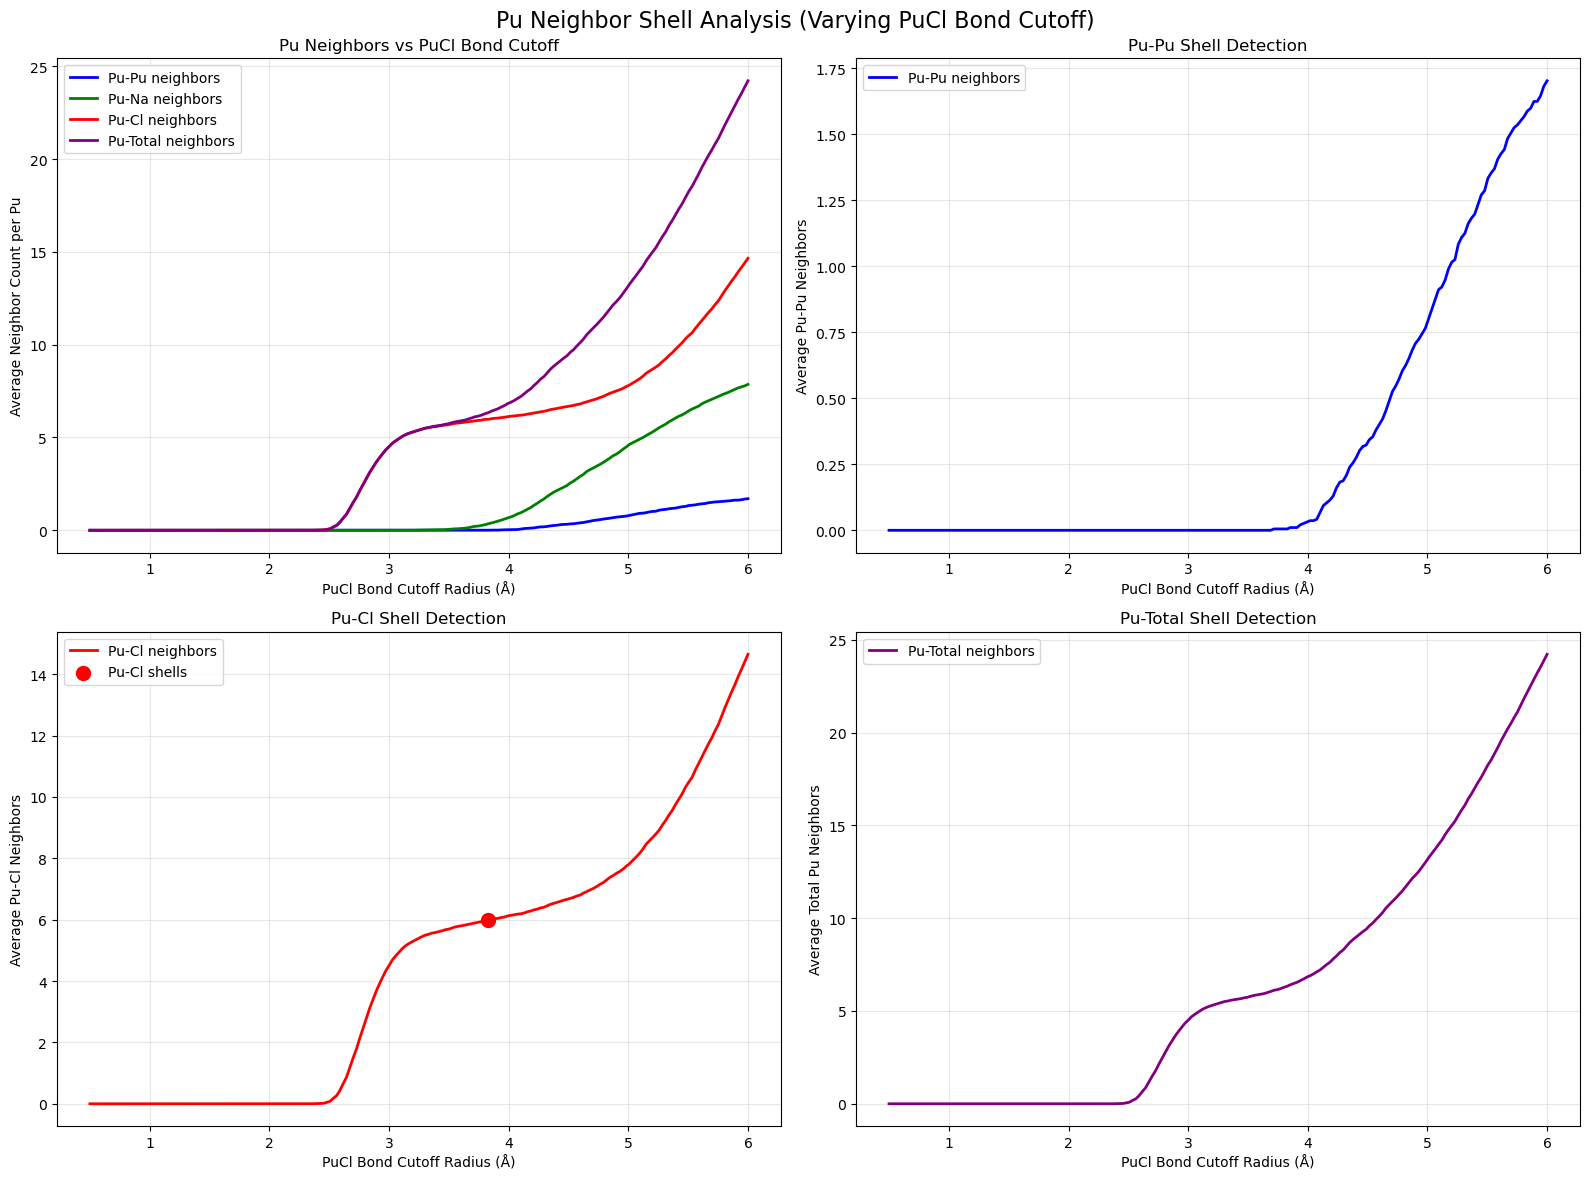


PU NEIGHBOR SHELL ANALYSIS RESULTS:

Pu-Pu Neighbors:
  Max Pu-Pu neighbors: 1.70
  Shells detected: 0

Pu-Na Neighbors:
  Max Pu-Na neighbors: 7.86

Pu-Cl Neighbors:
  Max Pu-Cl neighbors: 14.65
  Shells detected: 1
  Shell radii: ['3.828'] Å

Pu-Total Neighbors:
  Max Pu-Total neighbors: 24.22
  Shells detected: 0


In [5]:
pu_shell_analysis = analyze_pu_neighbor_shells(pipe, names, cutoffs, max_radius=6.0)
#octahedral
#nacl
#vesta - 

Running Pu neighbor shell analysis...
PU NEIGHBOR SHELL ANALYSIS
Analyzing 201 radius points for Pu neighbors...


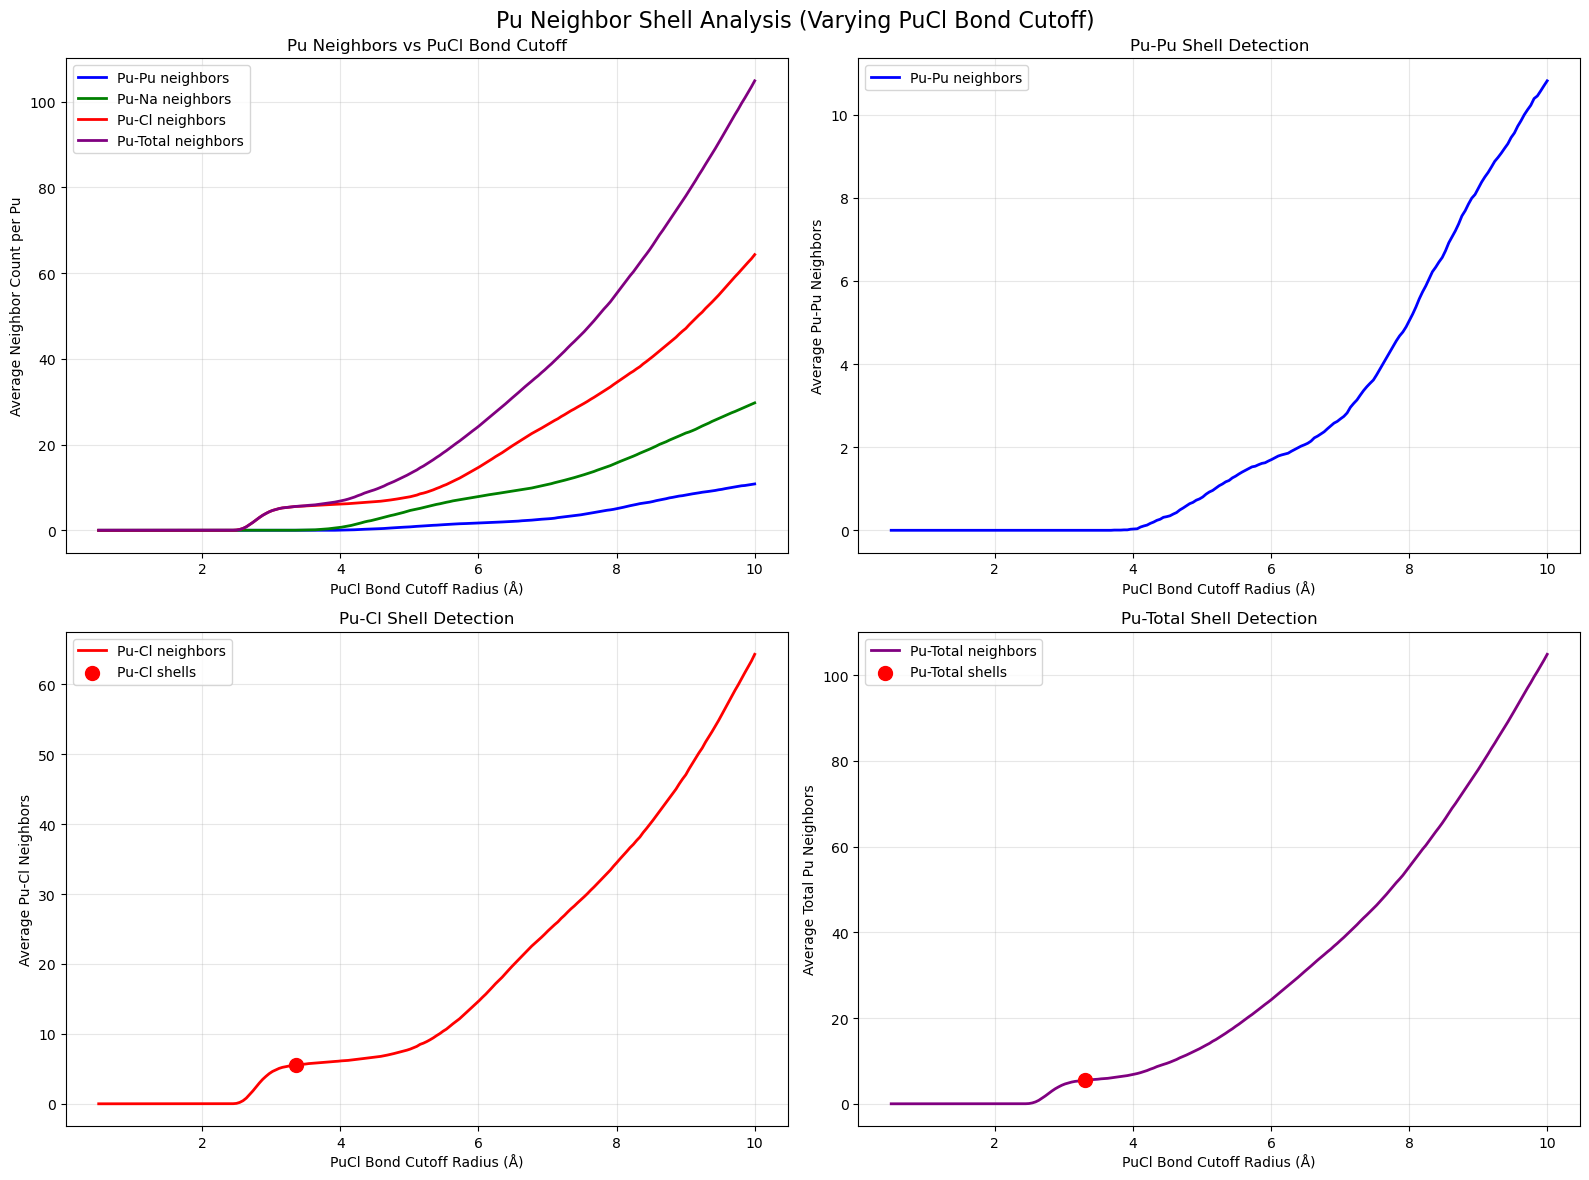


PU NEIGHBOR SHELL ANALYSIS RESULTS:

Pu-Pu Neighbors:
  Max Pu-Pu neighbors: 10.81
  Shells detected: 0

Pu-Na Neighbors:
  Max Pu-Na neighbors: 29.72

Pu-Cl Neighbors:
  Max Pu-Cl neighbors: 64.30
  Shells detected: 1
  Shell radii: ['3.350'] Å

Pu-Total Neighbors:
  Max Pu-Total neighbors: 104.84
  Shells detected: 1
  Shell radii: ['3.303'] Å


In [6]:
# Example 1: Pu neighbor shell analysis (focusing on PuCl bond cutoff)
print("Running Pu neighbor shell analysis...")
pu_shell_analysis = analyze_pu_neighbor_shells(pipe, names, cutoffs, max_radius=10.0)


Running comprehensive species-based analysis...
COMPREHENSIVE SPECIES-BASED SHELL ANALYSIS
Analyzing 201 radius points for all species...


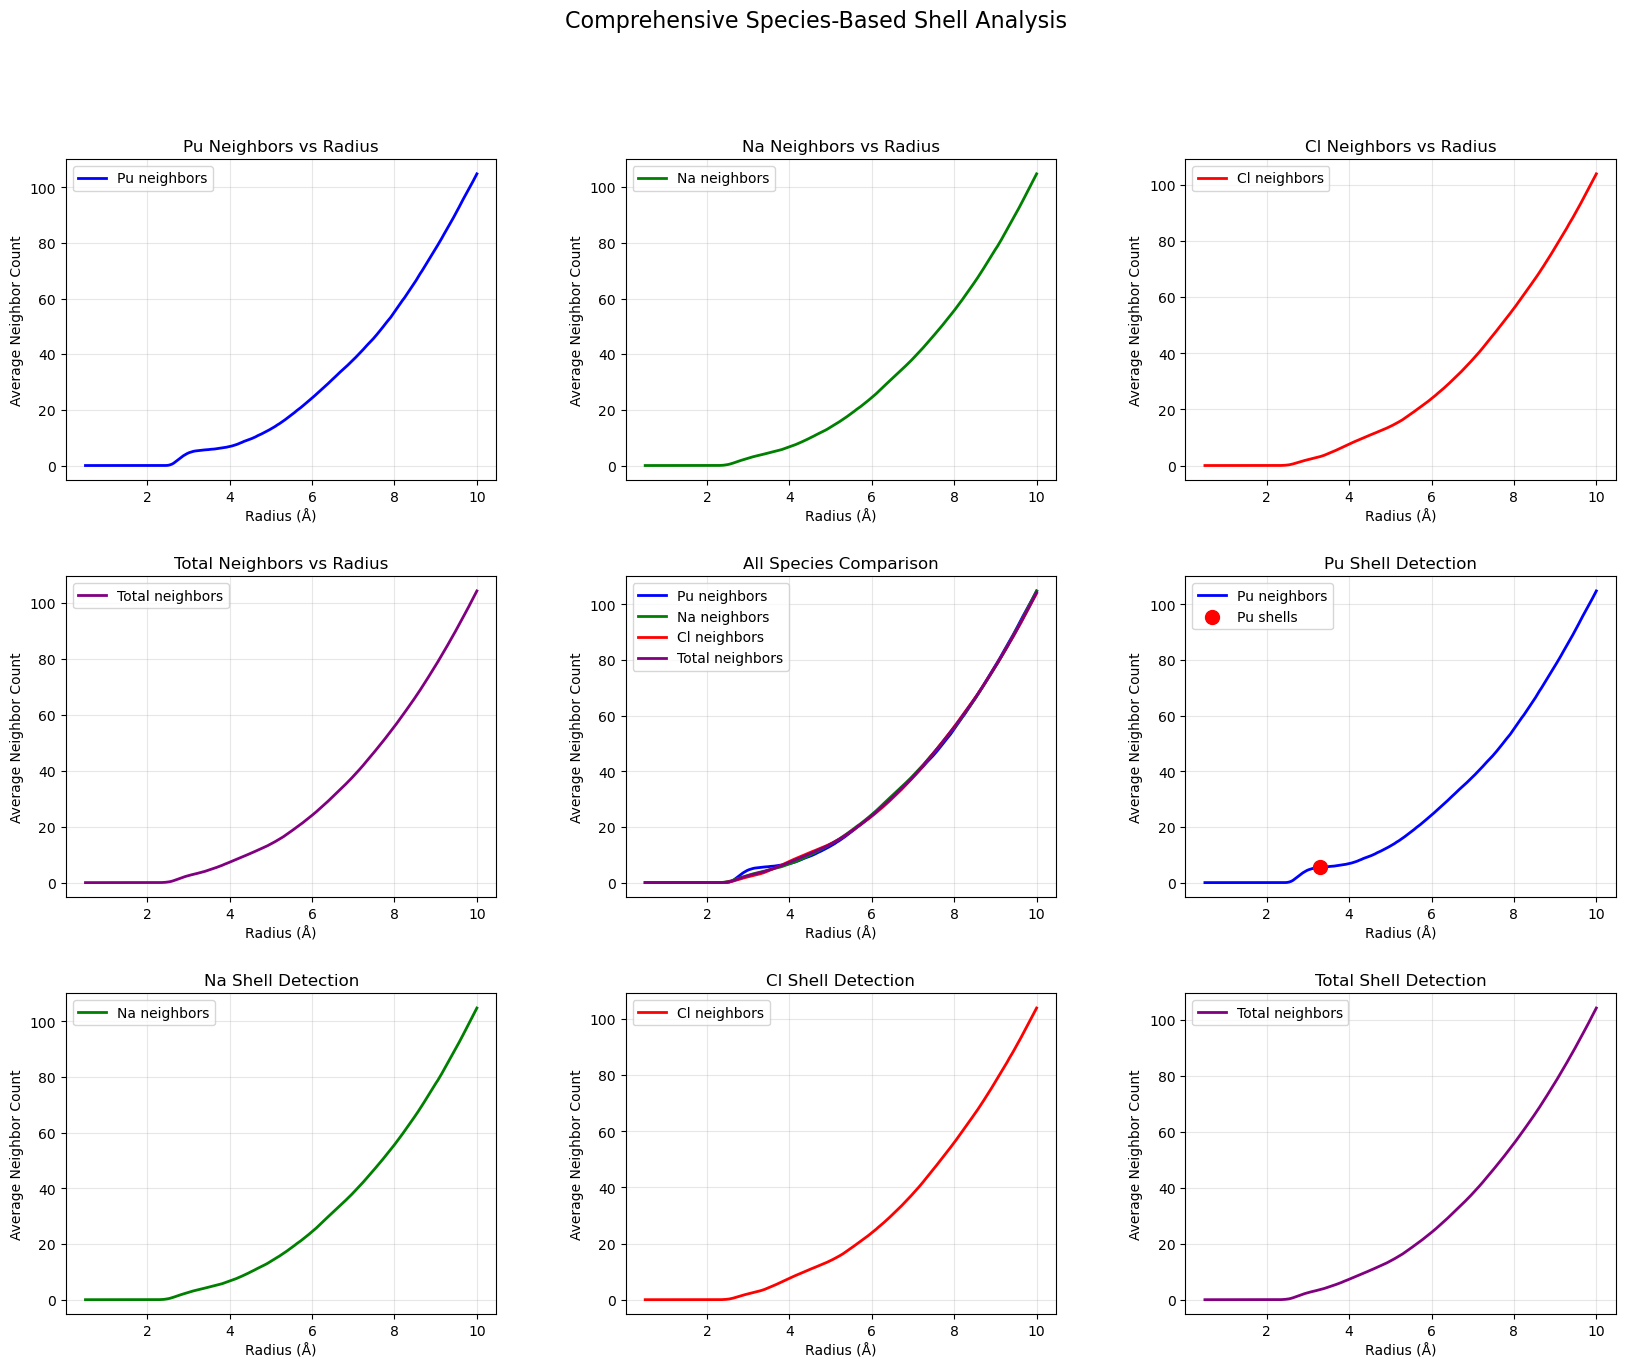


DETAILED SHELL ANALYSIS RESULTS:

Pu Neighbors Analysis:
  Number of Pu atoms: 384
  Max neighbors: 104.84
  Shells detected: 1
  Shell radii: ['3.303'] Å

Na Neighbors Analysis:
  Number of Na atoms: 1024
  Max neighbors: 104.82
  Shells detected: 0

Cl Neighbors Analysis:
  Number of Cl atoms: 2176
  Max neighbors: 103.97
  Shells detected: 0

Total Neighbors Analysis:
  Total atoms: 3584
  Max neighbors: 104.30
  Shells detected: 0

SUMMARY:
  Total shells detected across all species: 1
  Most shells in: Pu


In [7]:
# Example 2: Comprehensive species-based analysis (if you want to compare with other species)
print("Running comprehensive species-based analysis...")
species_analysis = analyze_all_species_neighbors(pipe, names, cutoffs, max_radius=10.0)


## Quick Analysis Functions


In [8]:
def quick_pu_shell_analysis(pipe, names, cutoffs, max_radius=10.0):
    """
    Quick Pu shell analysis - focuses on Pu neighbors with PuCl bond cutoff variation.
    """
    print("Running quick Pu shell analysis...")
    
    # Run Pu-specific shell analysis
    pu_shell_analysis = analyze_pu_neighbor_shells(pipe, names, cutoffs, max_radius)
    
    return pu_shell_analysis

# Example usage:
# quick_pu_shell_analysis(pipe, names, cutoffs)



PU-CENTERED COORDINATION ANALYSIS


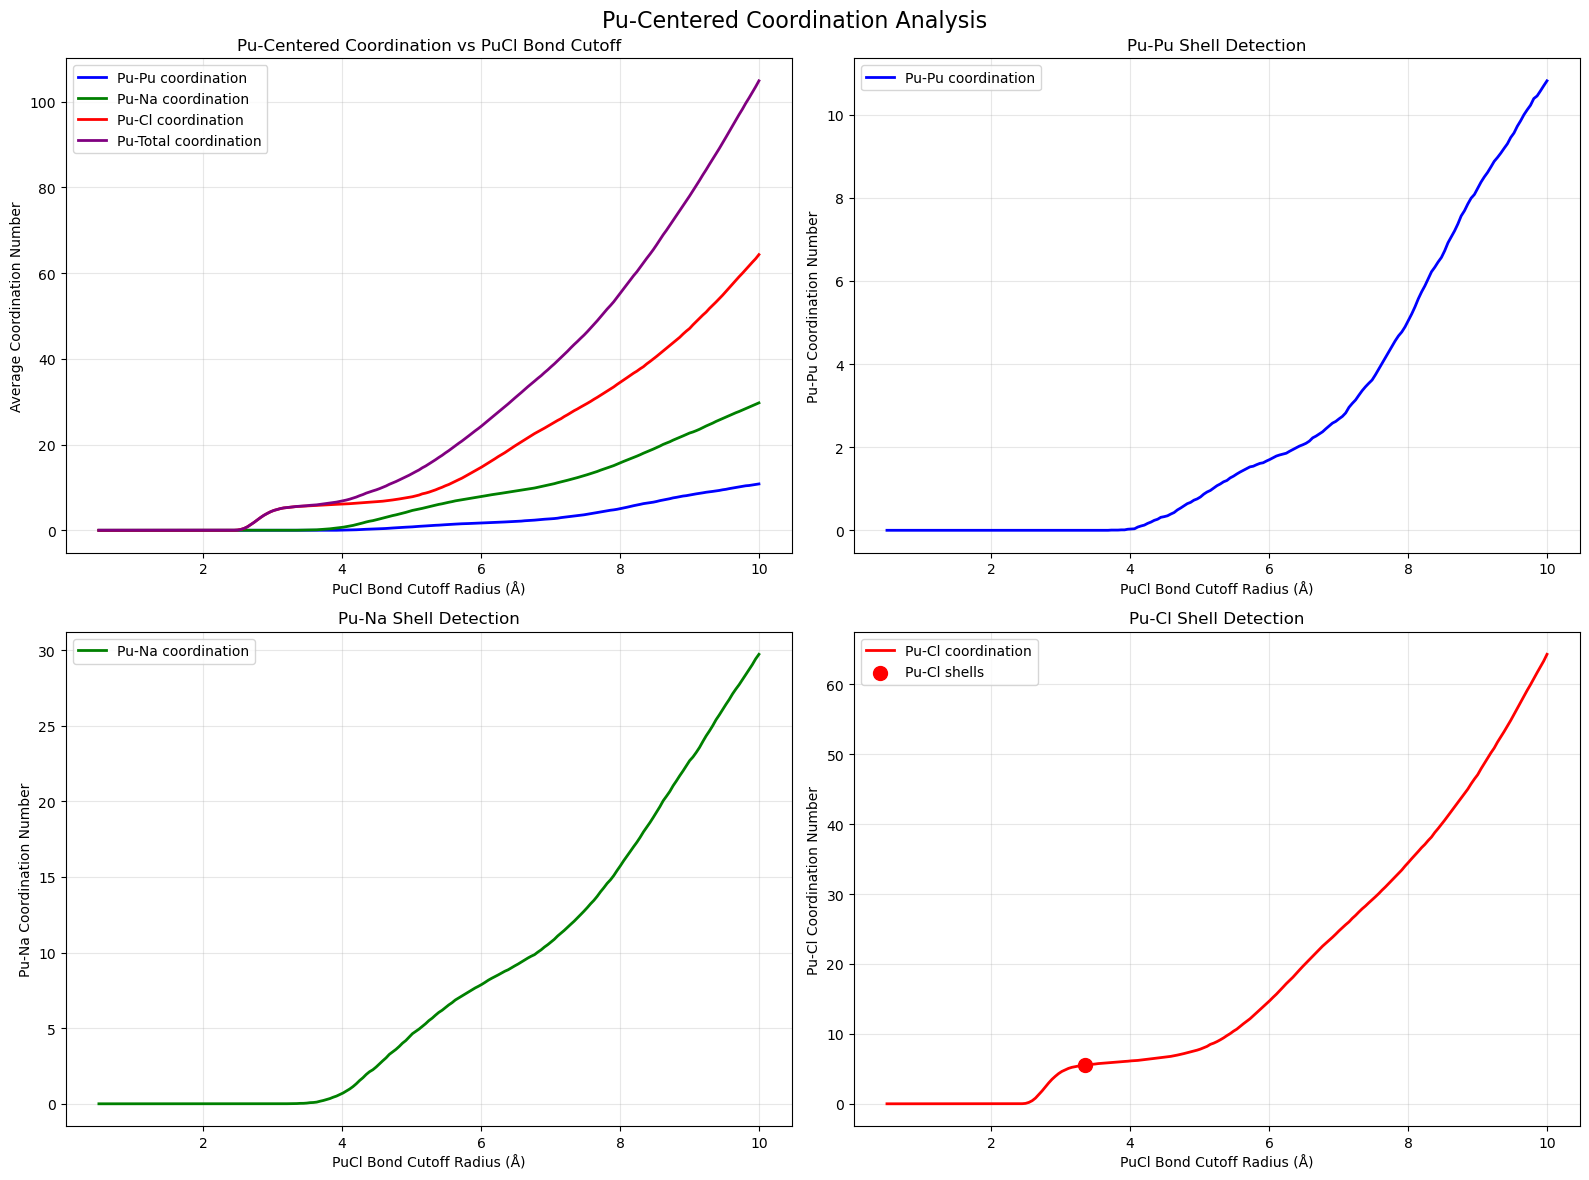


PU-CENTERED COORDINATION STATISTICS:

Pu-Pu Coordination:
  Max Pu-Pu coordination: 10.81
  Shells detected: 0

Pu-Na Coordination:
  Max Pu-Na coordination: 29.72
  Shells detected: 0

Pu-Cl Coordination:
  Max Pu-Cl coordination: 64.30
  Shells detected: 1
  Shell radii: ['3.350'] Å
  Coordination at shells: ['5.5']

Coordination at Specific Radii:
  At 2.0 Å:
    Pu-Pu: 0.00
    Pu-Na: 0.00
    Pu-Cl: 0.00
    Total: 0.00
  At 3.0 Å:
    Pu-Pu: 0.00
    Pu-Na: 0.00
    Pu-Cl: 4.63
    Total: 4.63
  At 4.0 Å:
    Pu-Pu: 0.03
    Pu-Na: 0.72
    Pu-Cl: 6.14
    Total: 6.89
  At 5.0 Å:
    Pu-Pu: 0.80
    Pu-Na: 4.64
    Pu-Cl: 7.83
    Total: 13.27
  At 6.0 Å:
    Pu-Pu: 1.70
    Pu-Na: 7.89
    Pu-Cl: 14.76
    Total: 24.36
  At 8.0 Å:
    Pu-Pu: 5.05
    Pu-Na: 15.73
    Pu-Cl: 34.53
    Total: 55.31
  At 10.0 Å:
    Pu-Pu: 10.81
    Pu-Na: 29.72
    Pu-Cl: 64.30
    Total: 104.84


In [9]:
# Pu-Centered Coordination Analysis
def analyze_pu_centered_coordination(pu_shell_analysis):
    """
    Analyze coordination distributions centered on Pu atoms.
    
    Shows how Pu, Na, and Cl atoms coordinate with Pu as the central atom
    as PuCl bond cutoff varies.
    
    Args:
        pu_shell_analysis: Results from analyze_pu_neighbor_shells function
    """
    print("\n" + "=" * 60)
    print("PU-CENTERED COORDINATION ANALYSIS")
    print("=" * 60)
    
    radius_range = pu_shell_analysis['radius_range']
    pu_pu_neighbors = pu_shell_analysis['pu_pu_neighbors']
    pu_na_neighbors = pu_shell_analysis['pu_na_neighbors']
    pu_cl_neighbors = pu_shell_analysis['pu_cl_neighbors']
    pu_total_neighbors = pu_shell_analysis['pu_total_neighbors']
    
    # Create Pu-centered coordination analysis plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: All coordination types with Pu as central atom
    ax1.plot(radius_range, pu_pu_neighbors, 'b-', linewidth=2, label='Pu-Pu coordination')
    ax1.plot(radius_range, pu_na_neighbors, 'g-', linewidth=2, label='Pu-Na coordination')
    ax1.plot(radius_range, pu_cl_neighbors, 'r-', linewidth=2, label='Pu-Cl coordination')
    ax1.plot(radius_range, pu_total_neighbors, 'purple', linewidth=2, label='Pu-Total coordination')
    ax1.set_xlabel('PuCl Bond Cutoff Radius (Å)')
    ax1.set_ylabel('Average Coordination Number')
    ax1.set_title('Pu-Centered Coordination vs PuCl Bond Cutoff')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Pu-Pu coordination with shell detection
    pu_pu_gradients = np.gradient(pu_pu_neighbors)
    pu_pu_second_deriv = np.gradient(pu_pu_gradients)
    pu_pu_shells = detect_proper_shells(pu_pu_gradients)
    
    ax2.plot(radius_range, pu_pu_neighbors, 'b-', linewidth=2, label='Pu-Pu coordination')
    if len(pu_pu_shells) > 0:
        pu_pu_shell_radii = radius_range[pu_pu_shells]
        pu_pu_shell_counts = [pu_pu_neighbors[i] for i in pu_pu_shells]
        ax2.scatter(pu_pu_shell_radii, pu_pu_shell_counts, color='red', s=100, zorder=5, label='Pu-Pu shells')
    ax2.set_xlabel('PuCl Bond Cutoff Radius (Å)')
    ax2.set_ylabel('Pu-Pu Coordination Number')
    ax2.set_title('Pu-Pu Shell Detection')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Pu-Na coordination with shell detection
    pu_na_gradients = np.gradient(pu_na_neighbors)
    pu_na_second_deriv = np.gradient(pu_na_gradients)
    pu_na_shells = detect_proper_shells(pu_na_gradients)
    
    ax3.plot(radius_range, pu_na_neighbors, 'g-', linewidth=2, label='Pu-Na coordination')
    if len(pu_na_shells) > 0:
        pu_na_shell_radii = radius_range[pu_na_shells]
        pu_na_shell_counts = [pu_na_neighbors[i] for i in pu_na_shells]
        ax3.scatter(pu_na_shell_radii, pu_na_shell_counts, color='red', s=100, zorder=5, label='Pu-Na shells')
    ax3.set_xlabel('PuCl Bond Cutoff Radius (Å)')
    ax3.set_ylabel('Pu-Na Coordination Number')
    ax3.set_title('Pu-Na Shell Detection')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Pu-Cl coordination with shell detection
    pu_cl_gradients = np.gradient(pu_cl_neighbors)
    pu_cl_second_deriv = np.gradient(pu_cl_gradients)
    pu_cl_shells = detect_proper_shells(pu_cl_gradients)
    
    ax4.plot(radius_range, pu_cl_neighbors, 'r-', linewidth=2, label='Pu-Cl coordination')
    if len(pu_cl_shells) > 0:
        pu_cl_shell_radii = radius_range[pu_cl_shells]
        pu_cl_shell_counts = [pu_cl_neighbors[i] for i in pu_cl_shells]
        ax4.scatter(pu_cl_shell_radii, pu_cl_shell_counts, color='red', s=100, zorder=5, label='Pu-Cl shells')
    ax4.set_xlabel('PuCl Bond Cutoff Radius (Å)')
    ax4.set_ylabel('Pu-Cl Coordination Number')
    ax4.set_title('Pu-Cl Shell Detection')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Pu-Centered Coordination Analysis', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print detailed coordination statistics
    print(f"\nPU-CENTERED COORDINATION STATISTICS:")
    print(f"=" * 50)
    
    # Pu-Pu coordination analysis
    print(f"\nPu-Pu Coordination:")
    print(f"  Max Pu-Pu coordination: {max(pu_pu_neighbors):.2f}")
    print(f"  Shells detected: {len(pu_pu_shells)}")
    if len(pu_pu_shells) > 0:
        pu_pu_shell_radii = radius_range[pu_pu_shells]
        print(f"  Shell radii: {[f'{r:.3f}' for r in pu_pu_shell_radii]} Å")
        print(f"  Coordination at shells: {[f'{pu_pu_neighbors[i]:.1f}' for i in pu_pu_shells]}")
    
    # Pu-Na coordination analysis
    print(f"\nPu-Na Coordination:")
    print(f"  Max Pu-Na coordination: {max(pu_na_neighbors):.2f}")
    print(f"  Shells detected: {len(pu_na_shells)}")
    if len(pu_na_shells) > 0:
        pu_na_shell_radii = radius_range[pu_na_shells]
        print(f"  Shell radii: {[f'{r:.3f}' for r in pu_na_shell_radii]} Å")
        print(f"  Coordination at shells: {[f'{pu_na_neighbors[i]:.1f}' for i in pu_na_shells]}")
    
    # Pu-Cl coordination analysis
    print(f"\nPu-Cl Coordination:")
    print(f"  Max Pu-Cl coordination: {max(pu_cl_neighbors):.2f}")
    print(f"  Shells detected: {len(pu_cl_shells)}")
    if len(pu_cl_shells) > 0:
        pu_cl_shell_radii = radius_range[pu_cl_shells]
        print(f"  Shell radii: {[f'{r:.3f}' for r in pu_cl_shell_radii]} Å")
        print(f"  Coordination at shells: {[f'{pu_cl_neighbors[i]:.1f}' for i in pu_cl_shells]}")
    
    # Coordination at specific radii
    print(f"\nCoordination at Specific Radii:")
    print(f"=" * 35)
    for r in [2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0]:
        r_idx = np.argmin(np.abs(radius_range - r))
        if r_idx < len(radius_range):
            print(f"  At {r:.1f} Å:")
            print(f"    Pu-Pu: {pu_pu_neighbors[r_idx]:.2f}")
            print(f"    Pu-Na: {pu_na_neighbors[r_idx]:.2f}")
            print(f"    Pu-Cl: {pu_cl_neighbors[r_idx]:.2f}")
            print(f"    Total: {pu_total_neighbors[r_idx]:.2f}")
    
    return {
        'pu_pu_shells': pu_pu_shells,
        'pu_na_shells': pu_na_shells,
        'pu_cl_shells': pu_cl_shells,
        'radius_range': radius_range
    }

# Run the Pu-centered coordination analysis
pu_coord_analysis = analyze_pu_centered_coordination(pu_shell_analysis)



PU NEIGHBOR DISTRIBUTION HISTOGRAMS
Analyzing Pu neighbor distributions at 7 key distances...
  Processing radius 2.0 Å...
  Processing radius 3.0 Å...
  Processing radius 4.0 Å...
  Processing radius 5.0 Å...
  Processing radius 6.0 Å...
  Processing radius 8.0 Å...
  Processing radius 10.0 Å...


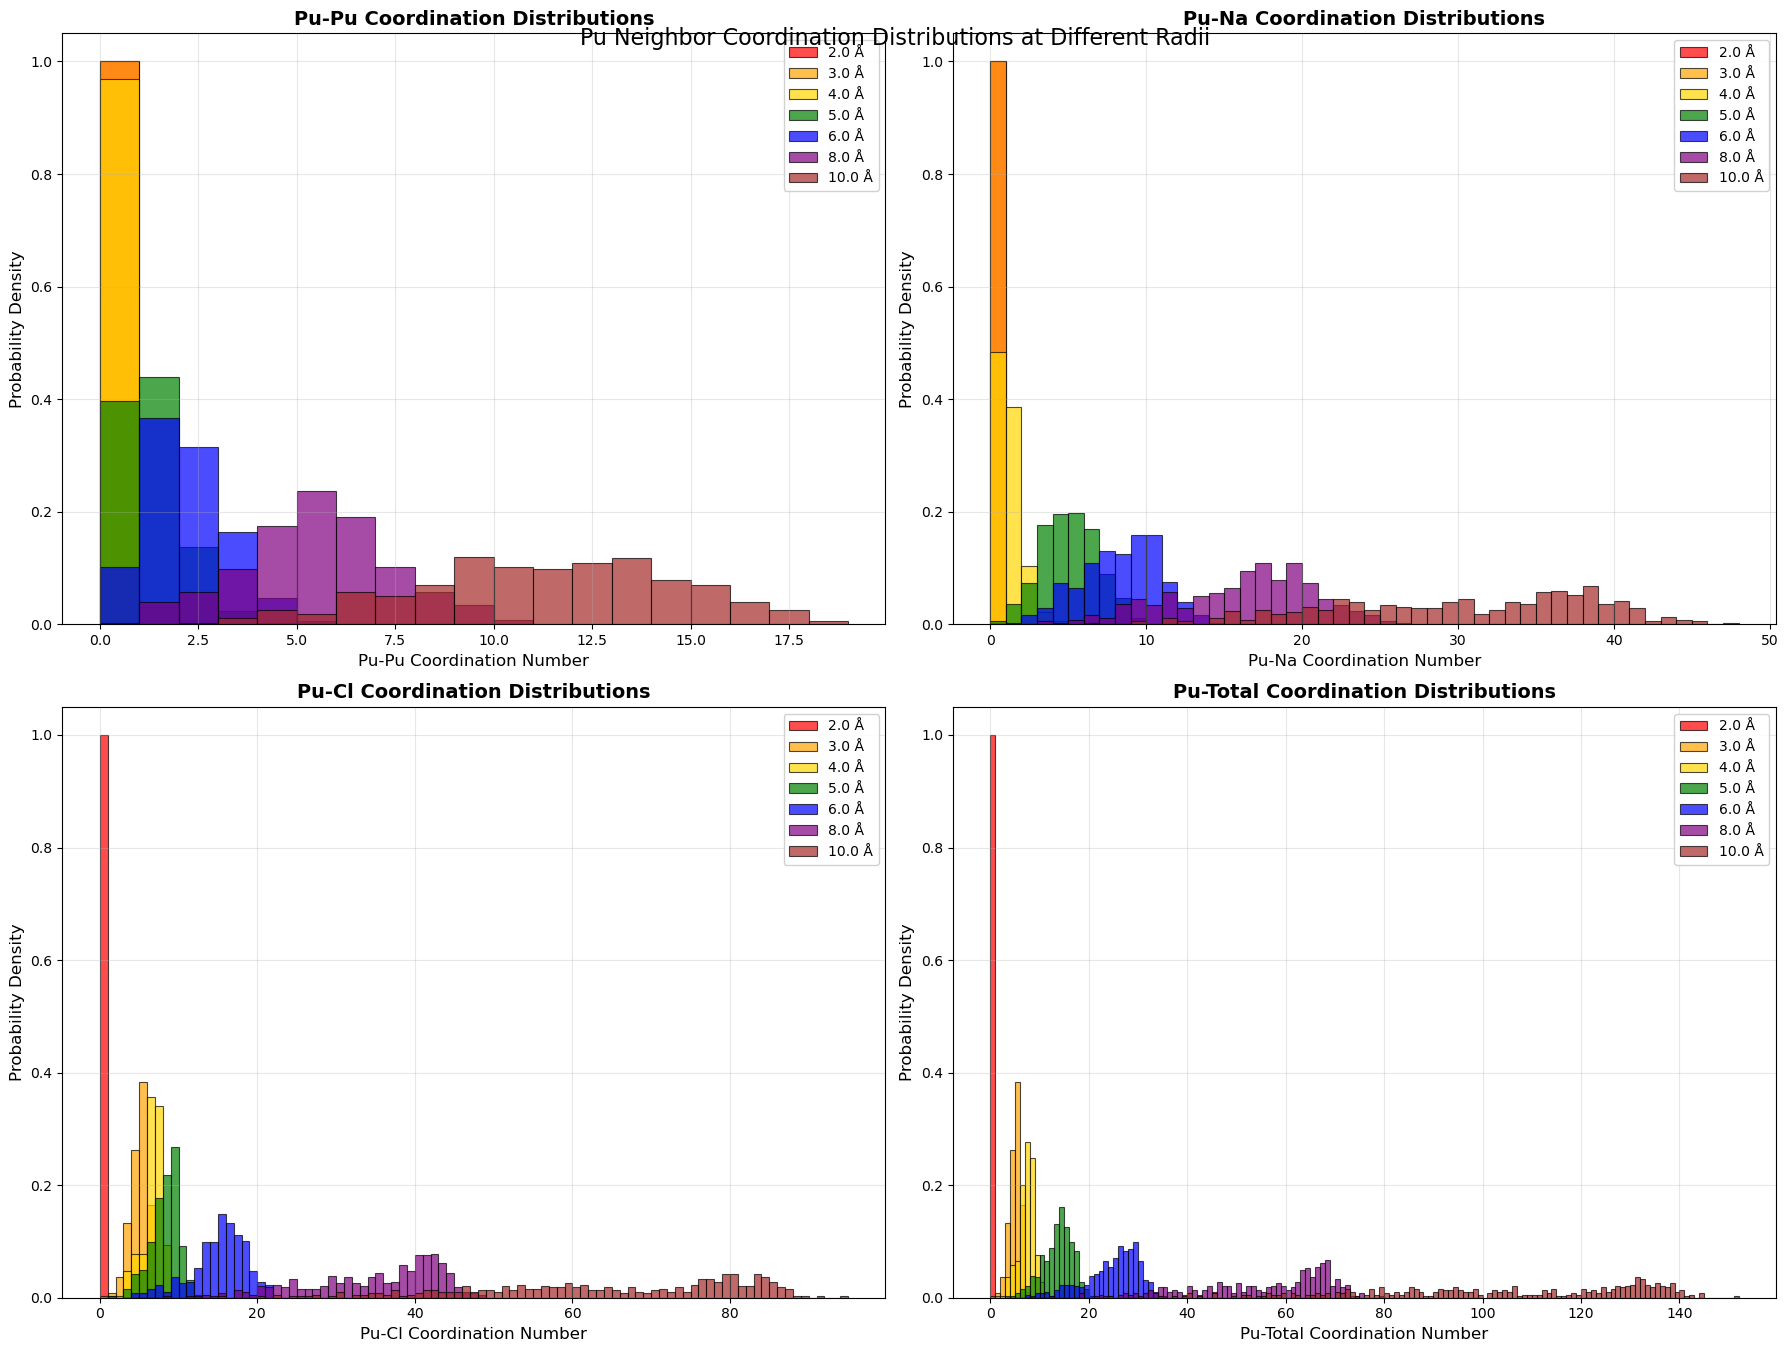

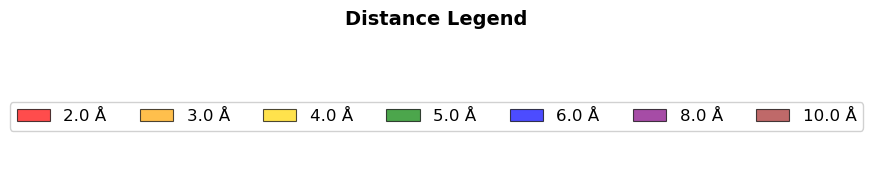


PU NEIGHBOR DISTRIBUTION STATISTICS:

At 2.0 Å:
  Pu-Pu: mean=0.00, std=0.00, range=0-0
  Pu-Na: mean=0.00, std=0.00, range=0-0
  Pu-Cl: mean=0.00, std=0.00, range=0-0
  Total: mean=0.00, std=0.00, range=0-0

At 3.0 Å:
  Pu-Pu: mean=0.00, std=0.00, range=0-0
  Pu-Na: mean=0.00, std=0.00, range=0-0
  Pu-Cl: mean=4.50, std=1.13, range=0-7
  Total: mean=4.50, std=1.13, range=0-7

At 4.0 Å:
  Pu-Pu: mean=0.03, std=0.17, range=0-1
  Pu-Na: mean=0.68, std=0.78, range=0-4
  Pu-Cl: mean=6.13, std=1.27, range=1-8
  Total: mean=6.84, std=1.62, range=1-11

At 5.0 Å:
  Pu-Pu: mean=0.80, std=0.78, range=0-4
  Pu-Na: mean=4.59, std=1.79, range=0-9
  Pu-Cl: mean=7.78, std=1.78, range=1-12
  Total: mean=13.16, std=3.06, range=3-20

At 6.0 Å:
  Pu-Pu: mean=1.70, std=1.04, range=0-5
  Pu-Na: mean=7.86, std=2.51, range=1-14
  Pu-Cl: mean=14.65, std=3.47, range=4-21
  Total: mean=24.22, std=5.53, range=7-35

At 8.0 Å:
  Pu-Pu: mean=5.03, std=1.90, range=0-10
  Pu-Na: mean=15.71, std=4.54, range=3-26
  Pu

In [10]:
# Pu Neighbor Distribution Histograms
def analyze_pu_neighbor_distributions(pipe, names, cutoffs, max_radius=10.0):
    """
    Build histograms showing Pu neighbor distributions at key distances.
    
    Shows coordination number distributions for Pu-Pu, Pu-Na, Pu-Cl, and Pu-Total
    neighbors at different PuCl bond cutoff radii.
    
    Args:
        pipe: OVITO pipeline object
        names: Array of atom names/types
        cutoffs: Dictionary of current cutoff values
        max_radius: Maximum radius to analyze
    
    Returns:
        Dictionary with neighbor distribution data
    """
    print("\n" + "=" * 60)
    print("PU NEIGHBOR DISTRIBUTION HISTOGRAMS")
    print("=" * 60)
    
    # Key distances to analyze with distinct colors and clear labels
    key_distances = [2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0]
    colors = ['red', 'orange', 'gold', 'green', 'blue', 'purple', 'brown']
    distance_labels = ['2.0 Å', '3.0 Å', '4.0 Å', '5.0 Å', '6.0 Å', '8.0 Å', '10.0 Å']
    
    # Store coordination distributions for each distance
    pu_pu_distributions = {}
    pu_na_distributions = {}
    pu_cl_distributions = {}
    pu_total_distributions = {}
    
    print(f"Analyzing Pu neighbor distributions at {len(key_distances)} key distances...")
    
    for r in key_distances:
        print(f"  Processing radius {r:.1f} Å...")
        
        # Set up bonds for this radius
        pair_cutoffs = {
            ("Pu","Cl"): float(r), ("Cl","Pu"): float(r),
            ("Na","Cl"): cutoffs.get(("Na","Cl"), 3.42), ("Cl","Na"): cutoffs.get(("Na","Cl"), 3.42),
        }
        configure_bonds_modifier_from_cutoffs(pipe, pair_cutoffs)
        data_temp = pipe.compute(0)
        
        positions = data_temp.particles.positions
        
        # Analyze Pu neighbors
        pu_atoms = np.where(names == "Pu")[0]
        pu_pu_coords = []
        pu_na_coords = []
        pu_cl_coords = []
        pu_total_coords = []
        
        for pu_idx in pu_atoms:
            pu_pos = positions[pu_idx]
            
            # Count Pu-Pu neighbors
            pu_positions = positions[names == "Pu"]
            pu_distances = np.linalg.norm(pu_positions - pu_pos, axis=1)
            pu_pu_neighbors_at_r = np.sum((pu_distances <= r) & (pu_distances > 0))  # Exclude self
            pu_pu_coords.append(pu_pu_neighbors_at_r)
            
            # Count Pu-Na neighbors
            na_positions = positions[names == "Na"]
            na_distances = np.linalg.norm(na_positions - pu_pos, axis=1)
            pu_na_neighbors_at_r = np.sum(na_distances <= r)
            pu_na_coords.append(pu_na_neighbors_at_r)
            
            # Count Pu-Cl neighbors
            cl_positions = positions[names == "Cl"]
            cl_distances = np.linalg.norm(cl_positions - pu_pos, axis=1)
            pu_cl_neighbors_at_r = np.sum(cl_distances <= r)
            pu_cl_coords.append(pu_cl_neighbors_at_r)
            
            # Total neighbors
            pu_total_neighbors_at_r = pu_pu_neighbors_at_r + pu_na_neighbors_at_r + pu_cl_neighbors_at_r
            pu_total_coords.append(pu_total_neighbors_at_r)
        
        # Store distributions
        pu_pu_distributions[r] = pu_pu_coords
        pu_na_distributions[r] = pu_na_coords
        pu_cl_distributions[r] = pu_cl_coords
        pu_total_distributions[r] = pu_total_coords
    
    # Create histogram plots with clearer styling
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: Pu-Pu coordination distributions
    ax1.set_title('Pu-Pu Coordination Distributions', fontsize=14, fontweight='bold')
    for i, r in enumerate(key_distances):
        coord_dist = pu_pu_distributions[r]
        if len(coord_dist) > 0:
            max_coord = max(coord_dist)
            bins = range(max_coord + 2)
            ax1.hist(coord_dist, bins=bins, alpha=0.7, color=colors[i], 
                    label=distance_labels[i], density=True, edgecolor='black', linewidth=0.8)
    ax1.set_xlabel('Pu-Pu Coordination Number', fontsize=12)
    ax1.set_ylabel('Probability Density', fontsize=12)
    ax1.legend(fontsize=10, framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    ax1.set_facecolor('white')
    
    # Plot 2: Pu-Na coordination distributions
    ax2.set_title('Pu-Na Coordination Distributions', fontsize=14, fontweight='bold')
    for i, r in enumerate(key_distances):
        coord_dist = pu_na_distributions[r]
        if len(coord_dist) > 0:
            max_coord = max(coord_dist)
            bins = range(max_coord + 2)
            ax2.hist(coord_dist, bins=bins, alpha=0.7, color=colors[i], 
                    label=distance_labels[i], density=True, edgecolor='black', linewidth=0.8)
    ax2.set_xlabel('Pu-Na Coordination Number', fontsize=12)
    ax2.set_ylabel('Probability Density', fontsize=12)
    ax2.legend(fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    ax2.set_facecolor('white')
    
    # Plot 3: Pu-Cl coordination distributions
    ax3.set_title('Pu-Cl Coordination Distributions', fontsize=14, fontweight='bold')
    for i, r in enumerate(key_distances):
        coord_dist = pu_cl_distributions[r]
        if len(coord_dist) > 0:
            max_coord = max(coord_dist)
            bins = range(max_coord + 2)
            ax3.hist(coord_dist, bins=bins, alpha=0.7, color=colors[i], 
                    label=distance_labels[i], density=True, edgecolor='black', linewidth=0.8)
    ax3.set_xlabel('Pu-Cl Coordination Number', fontsize=12)
    ax3.set_ylabel('Probability Density', fontsize=12)
    ax3.legend(fontsize=10, framealpha=0.9)
    ax3.grid(True, alpha=0.3)
    ax3.set_facecolor('white')
    
    # Plot 4: Pu-Total coordination distributions
    ax4.set_title('Pu-Total Coordination Distributions', fontsize=14, fontweight='bold')
    for i, r in enumerate(key_distances):
        coord_dist = pu_total_distributions[r]
        if len(coord_dist) > 0:
            max_coord = max(coord_dist)
            bins = range(max_coord + 2)
            ax4.hist(coord_dist, bins=bins, alpha=0.7, color=colors[i], 
                    label=distance_labels[i], density=True, edgecolor='black', linewidth=0.8)
    ax4.set_xlabel('Pu-Total Coordination Number', fontsize=12)
    ax4.set_ylabel('Probability Density', fontsize=12)
    ax4.legend(fontsize=10, framealpha=0.9)
    ax4.grid(True, alpha=0.3)
    ax4.set_facecolor('white')
    
    plt.suptitle('Pu Neighbor Coordination Distributions at Different Radii', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Create a separate legend reference plot
    fig_legend, ax_legend = plt.subplots(figsize=(8, 2))
    ax_legend.set_xlim(0, 1)
    ax_legend.set_ylim(0, 1)
    ax_legend.axis('off')
    
    # Create legend patches
    legend_elements = []
    for i, (r, color) in enumerate(zip(key_distances, colors)):
        legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.7, 
                                           edgecolor='black', linewidth=0.8))
    
    ax_legend.legend(legend_elements, distance_labels, loc='center', ncol=len(key_distances), 
                   fontsize=12, framealpha=0.9)
    ax_legend.set_title('Distance Legend', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Print distribution statistics
    print(f"\nPU NEIGHBOR DISTRIBUTION STATISTICS:")
    print(f"=" * 50)
    
    for r in key_distances:
        print(f"\nAt {r:.1f} Å:")
        print(f"  Pu-Pu: mean={np.mean(pu_pu_distributions[r]):.2f}, std={np.std(pu_pu_distributions[r]):.2f}, range={min(pu_pu_distributions[r])}-{max(pu_pu_distributions[r])}")
        print(f"  Pu-Na: mean={np.mean(pu_na_distributions[r]):.2f}, std={np.std(pu_na_distributions[r]):.2f}, range={min(pu_na_distributions[r])}-{max(pu_na_distributions[r])}")
        print(f"  Pu-Cl: mean={np.mean(pu_cl_distributions[r]):.2f}, std={np.std(pu_cl_distributions[r]):.2f}, range={min(pu_cl_distributions[r])}-{max(pu_cl_distributions[r])}")
        print(f"  Total: mean={np.mean(pu_total_distributions[r]):.2f}, std={np.std(pu_total_distributions[r]):.2f}, range={min(pu_total_distributions[r])}-{max(pu_total_distributions[r])}")
    
    return {
        'key_distances': key_distances,
        'pu_pu_distributions': pu_pu_distributions,
        'pu_na_distributions': pu_na_distributions,
        'pu_cl_distributions': pu_cl_distributions,
        'pu_total_distributions': pu_total_distributions,
        'colors': colors,
        'distance_labels': distance_labels
    }

# Run the Pu neighbor distribution analysis
pu_dist_analysis = analyze_pu_neighbor_distributions(pipe, names, cutoffs, max_radius=10.0)



COORDINATION DERIVATIVES ANALYSIS


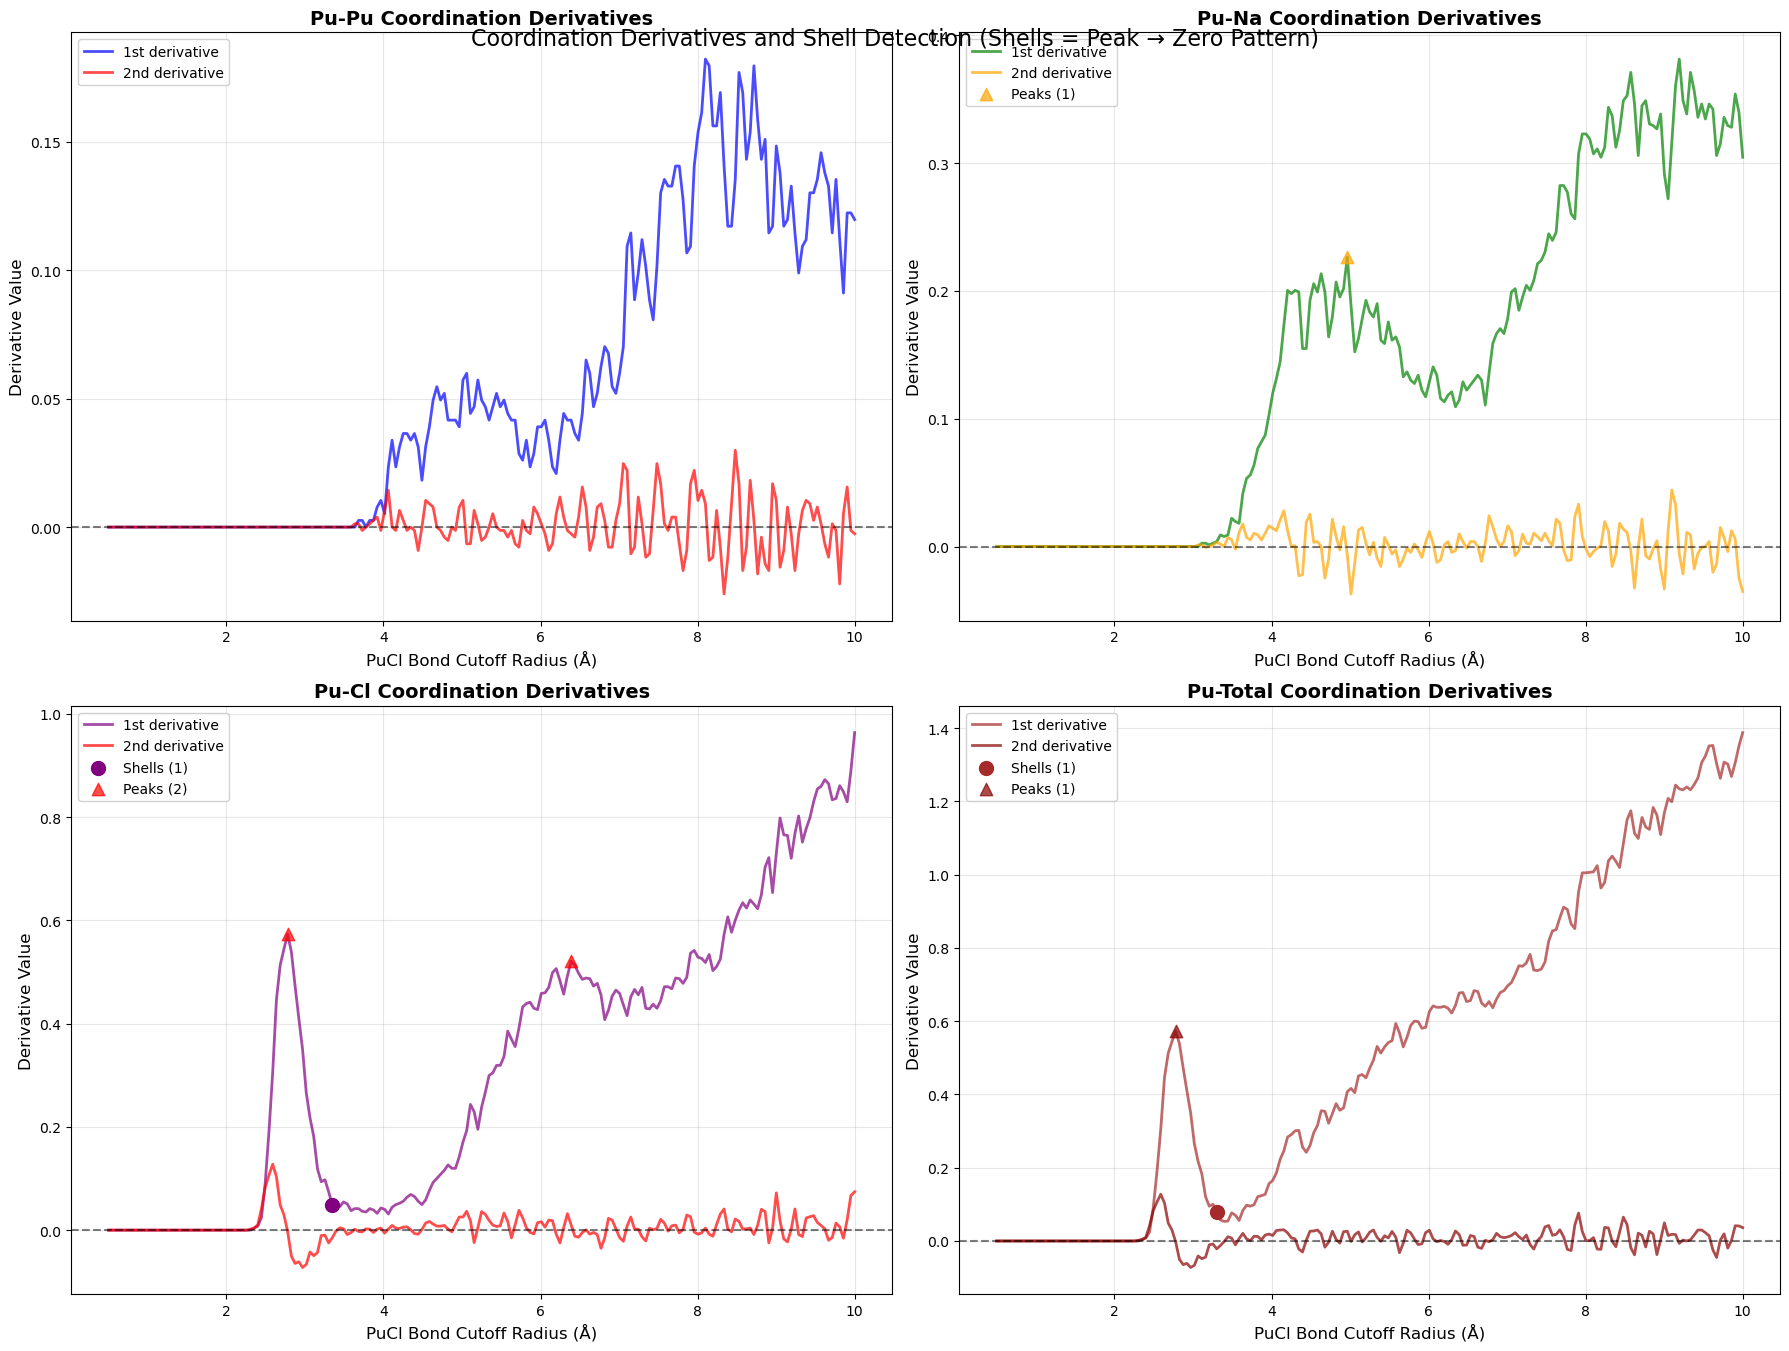


PROPER SHELL DETECTION ANALYSIS:

Pu-Pu Coordination:
  Derivative peaks found: 0
  Shell boundaries detected: 0

Pu-Na Coordination:
  Derivative peaks found: 1
  Shell boundaries detected: 0
  Peak radii: ['4.965'] Å

Pu-Cl Coordination:
  Derivative peaks found: 2
  Shell boundaries detected: 1
  Peak radii: ['2.780', '6.390'] Å
  Shell radii: ['3.350'] Å

Pu-Total Coordination:
  Derivative peaks found: 1
  Shell boundaries detected: 1
  Peak radii: ['2.780'] Å
  Shell radii: ['3.303'] Å


In [11]:
# Shell Detection Derivatives Analysis
def plot_coordination_derivatives(pu_shell_analysis):
    """
    Plot first and second derivatives of Pu coordination curves to visualize shell detection.
    
    Shows how the derivatives change with radius and where shells are detected.
    Shell boundaries are detected where first derivative peaks then goes to zero (proper shell formation pattern).
    
    Args:
        pu_shell_analysis: Results from analyze_pu_neighbor_shells function
    """
    print("\n" + "=" * 60)
    print("COORDINATION DERIVATIVES ANALYSIS")
    print("=" * 60)
    
    radius_range = pu_shell_analysis['radius_range']
    pu_pu_neighbors = pu_shell_analysis['pu_pu_neighbors']
    pu_na_neighbors = pu_shell_analysis['pu_na_neighbors']
    pu_cl_neighbors = pu_shell_analysis['pu_cl_neighbors']
    pu_total_neighbors = pu_shell_analysis['pu_total_neighbors']
    
    # Calculate first derivatives
    pu_pu_first_deriv = np.gradient(pu_pu_neighbors)
    pu_na_first_deriv = np.gradient(pu_na_neighbors)
    pu_cl_first_deriv = np.gradient(pu_cl_neighbors)
    pu_total_first_deriv = np.gradient(pu_total_neighbors)
    
    # Calculate second derivatives
    pu_pu_second_deriv = np.gradient(pu_pu_first_deriv)
    pu_na_second_deriv = np.gradient(pu_na_first_deriv)
    pu_cl_second_deriv = np.gradient(pu_cl_first_deriv)
    pu_total_second_deriv = np.gradient(pu_total_first_deriv)
    
    # Detect shells using proper pattern
    pu_pu_shells = detect_proper_shells(pu_pu_first_deriv)
    pu_na_shells = detect_proper_shells(pu_na_first_deriv)
    pu_cl_shells = detect_proper_shells(pu_cl_first_deriv)
    pu_total_shells = detect_proper_shells(pu_total_first_deriv)
    
    # Create derivative plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: Pu-Pu derivatives
    ax1.plot(radius_range, pu_pu_first_deriv, 'b-', linewidth=2, label='1st derivative', alpha=0.7)
    ax1.plot(radius_range, pu_pu_second_deriv, 'r-', linewidth=2, label='2nd derivative', alpha=0.7)
    
    # Mark detected shells (where first derivative goes to zero after peaking)
    if len(pu_pu_shells) > 0:
        shell_radii = radius_range[pu_pu_shells]
        shell_first_derivs = pu_pu_first_deriv[pu_pu_shells]
        ax1.scatter(shell_radii, shell_first_derivs, color='blue', s=100, zorder=5, 
                  label=f'Shells ({len(pu_pu_shells)})', marker='o')
    
    # Mark peaks in first derivative
    pu_pu_peaks, _ = find_peaks(pu_pu_first_deriv, prominence=0.1, distance=10)
    if len(pu_pu_peaks) > 0:
        peak_radii = radius_range[pu_pu_peaks]
        peak_derivs = pu_pu_first_deriv[pu_pu_peaks]
        ax1.scatter(peak_radii, peak_derivs, color='red', s=80, zorder=5, 
                   label=f'Peaks ({len(pu_pu_peaks)})', marker='^', alpha=0.7)
    
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('PuCl Bond Cutoff Radius (Å)', fontsize=12)
    ax1.set_ylabel('Derivative Value', fontsize=12)
    ax1.set_title('Pu-Pu Coordination Derivatives', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10, framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    ax1.set_facecolor('white')
    
    # Plot 2: Pu-Na derivatives
    ax2.plot(radius_range, pu_na_first_deriv, 'g-', linewidth=2, label='1st derivative', alpha=0.7)
    ax2.plot(radius_range, pu_na_second_deriv, 'orange', linewidth=2, label='2nd derivative', alpha=0.7)
    
    # Mark detected shells
    if len(pu_na_shells) > 0:
        shell_radii = radius_range[pu_na_shells]
        shell_first_derivs = pu_na_first_deriv[pu_na_shells]
        ax2.scatter(shell_radii, shell_first_derivs, color='green', s=100, zorder=5, 
                  label=f'Shells ({len(pu_na_shells)})', marker='o')
    
    # Mark peaks in first derivative
    pu_na_peaks, _ = find_peaks(pu_na_first_deriv, prominence=0.1, distance=10)
    if len(pu_na_peaks) > 0:
        peak_radii = radius_range[pu_na_peaks]
        peak_derivs = pu_na_first_deriv[pu_na_peaks]
        ax2.scatter(peak_radii, peak_derivs, color='orange', s=80, zorder=5, 
                   label=f'Peaks ({len(pu_na_peaks)})', marker='^', alpha=0.7)
    
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('PuCl Bond Cutoff Radius (Å)', fontsize=12)
    ax2.set_ylabel('Derivative Value', fontsize=12)
    ax2.set_title('Pu-Na Coordination Derivatives', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    ax2.set_facecolor('white')
    
    # Plot 3: Pu-Cl derivatives
    ax3.plot(radius_range, pu_cl_first_deriv, 'purple', linewidth=2, label='1st derivative', alpha=0.7)
    ax3.plot(radius_range, pu_cl_second_deriv, 'red', linewidth=2, label='2nd derivative', alpha=0.7)
    
    # Mark detected shells
    if len(pu_cl_shells) > 0:
        shell_radii = radius_range[pu_cl_shells]
        shell_first_derivs = pu_cl_first_deriv[pu_cl_shells]
        ax3.scatter(shell_radii, shell_first_derivs, color='purple', s=100, zorder=5, 
                  label=f'Shells ({len(pu_cl_shells)})', marker='o')
    
    # Mark peaks in first derivative
    pu_cl_peaks, _ = find_peaks(pu_cl_first_deriv, prominence=0.1, distance=10)
    if len(pu_cl_peaks) > 0:
        peak_radii = radius_range[pu_cl_peaks]
        peak_derivs = pu_cl_first_deriv[pu_cl_peaks]
        ax3.scatter(peak_radii, peak_derivs, color='red', s=80, zorder=5, 
                   label=f'Peaks ({len(pu_cl_peaks)})', marker='^', alpha=0.7)
    
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_xlabel('PuCl Bond Cutoff Radius (Å)', fontsize=12)
    ax3.set_ylabel('Derivative Value', fontsize=12)
    ax3.set_title('Pu-Cl Coordination Derivatives', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10, framealpha=0.9)
    ax3.grid(True, alpha=0.3)
    ax3.set_facecolor('white')
    
    # Plot 4: Pu-Total derivatives
    ax4.plot(radius_range, pu_total_first_deriv, 'brown', linewidth=2, label='1st derivative', alpha=0.7)
    ax4.plot(radius_range, pu_total_second_deriv, 'darkred', linewidth=2, label='2nd derivative', alpha=0.7)
    
    # Mark detected shells
    if len(pu_total_shells) > 0:
        shell_radii = radius_range[pu_total_shells]
        shell_first_derivs = pu_total_first_deriv[pu_total_shells]
        ax4.scatter(shell_radii, shell_first_derivs, color='brown', s=100, zorder=5, 
                  label=f'Shells ({len(pu_total_shells)})', marker='o')
    
    # Mark peaks in first derivative
    pu_total_peaks, _ = find_peaks(pu_total_first_deriv, prominence=0.1, distance=10)
    if len(pu_total_peaks) > 0:
        peak_radii = radius_range[pu_total_peaks]
        peak_derivs = pu_total_first_deriv[pu_total_peaks]
        ax4.scatter(peak_radii, peak_derivs, color='darkred', s=80, zorder=5, 
                   label=f'Peaks ({len(pu_total_peaks)})', marker='^', alpha=0.7)
    
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_xlabel('PuCl Bond Cutoff Radius (Å)', fontsize=12)
    ax4.set_ylabel('Derivative Value', fontsize=12)
    ax4.set_title('Pu-Total Coordination Derivatives', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=10, framealpha=0.9)
    ax4.grid(True, alpha=0.3)
    ax4.set_facecolor('white')
    
    plt.suptitle('Coordination Derivatives and Shell Detection (Shells = Peak → Zero Pattern)', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Print derivative analysis
    print(f"\nPROPER SHELL DETECTION ANALYSIS:")
    print(f"=" * 50)
    
    derivative_data = {
        'Pu-Pu': {'first': pu_pu_first_deriv, 'shells': pu_pu_shells, 'peaks': pu_pu_peaks},
        'Pu-Na': {'first': pu_na_first_deriv, 'shells': pu_na_shells, 'peaks': pu_na_peaks},
        'Pu-Cl': {'first': pu_cl_first_deriv, 'shells': pu_cl_shells, 'peaks': pu_cl_peaks},
        'Pu-Total': {'first': pu_total_first_deriv, 'shells': pu_total_shells, 'peaks': pu_total_peaks}
    }
    
    for coord_type, data in derivative_data.items():
        print(f"\n{coord_type} Coordination:")
        print(f"  Derivative peaks found: {len(data['peaks'])}")
        print(f"  Shell boundaries detected: {len(data['shells'])}")
        
        if len(data['peaks']) > 0:
            peak_radii = radius_range[data['peaks']]
            print(f"  Peak radii: {[f'{r:.3f}' for r in peak_radii]} Å")
        
        if len(data['shells']) > 0:
            shell_radii = radius_range[data['shells']]
            print(f"  Shell radii: {[f'{r:.3f}' for r in shell_radii]} Å")
    
    return {
        'radius_range': radius_range,
        'pu_pu_first_deriv': pu_pu_first_deriv,
        'pu_pu_second_deriv': pu_pu_second_deriv,
        'pu_na_first_deriv': pu_na_first_deriv,
        'pu_na_second_deriv': pu_na_second_deriv,
        'pu_cl_first_deriv': pu_cl_first_deriv,
        'pu_cl_second_deriv': pu_cl_second_deriv,
        'pu_total_first_deriv': pu_total_first_deriv,
        'pu_total_second_deriv': pu_total_second_deriv,
        'shells': {
            'pu_pu': pu_pu_shells,
            'pu_na': pu_na_shells,
            'pu_cl': pu_cl_shells,
            'pu_total': pu_total_shells
        },
        'peaks': {
            'pu_pu': pu_pu_peaks,
            'pu_na': pu_na_peaks,
            'pu_cl': pu_cl_peaks,
            'pu_total': pu_total_peaks
        }
    }

# Run the derivatives analysis
derivatives_analysis = plot_coordination_derivatives(pu_shell_analysis)



COORDINATION WITH FIRST DERIVATIVE OVERLAY


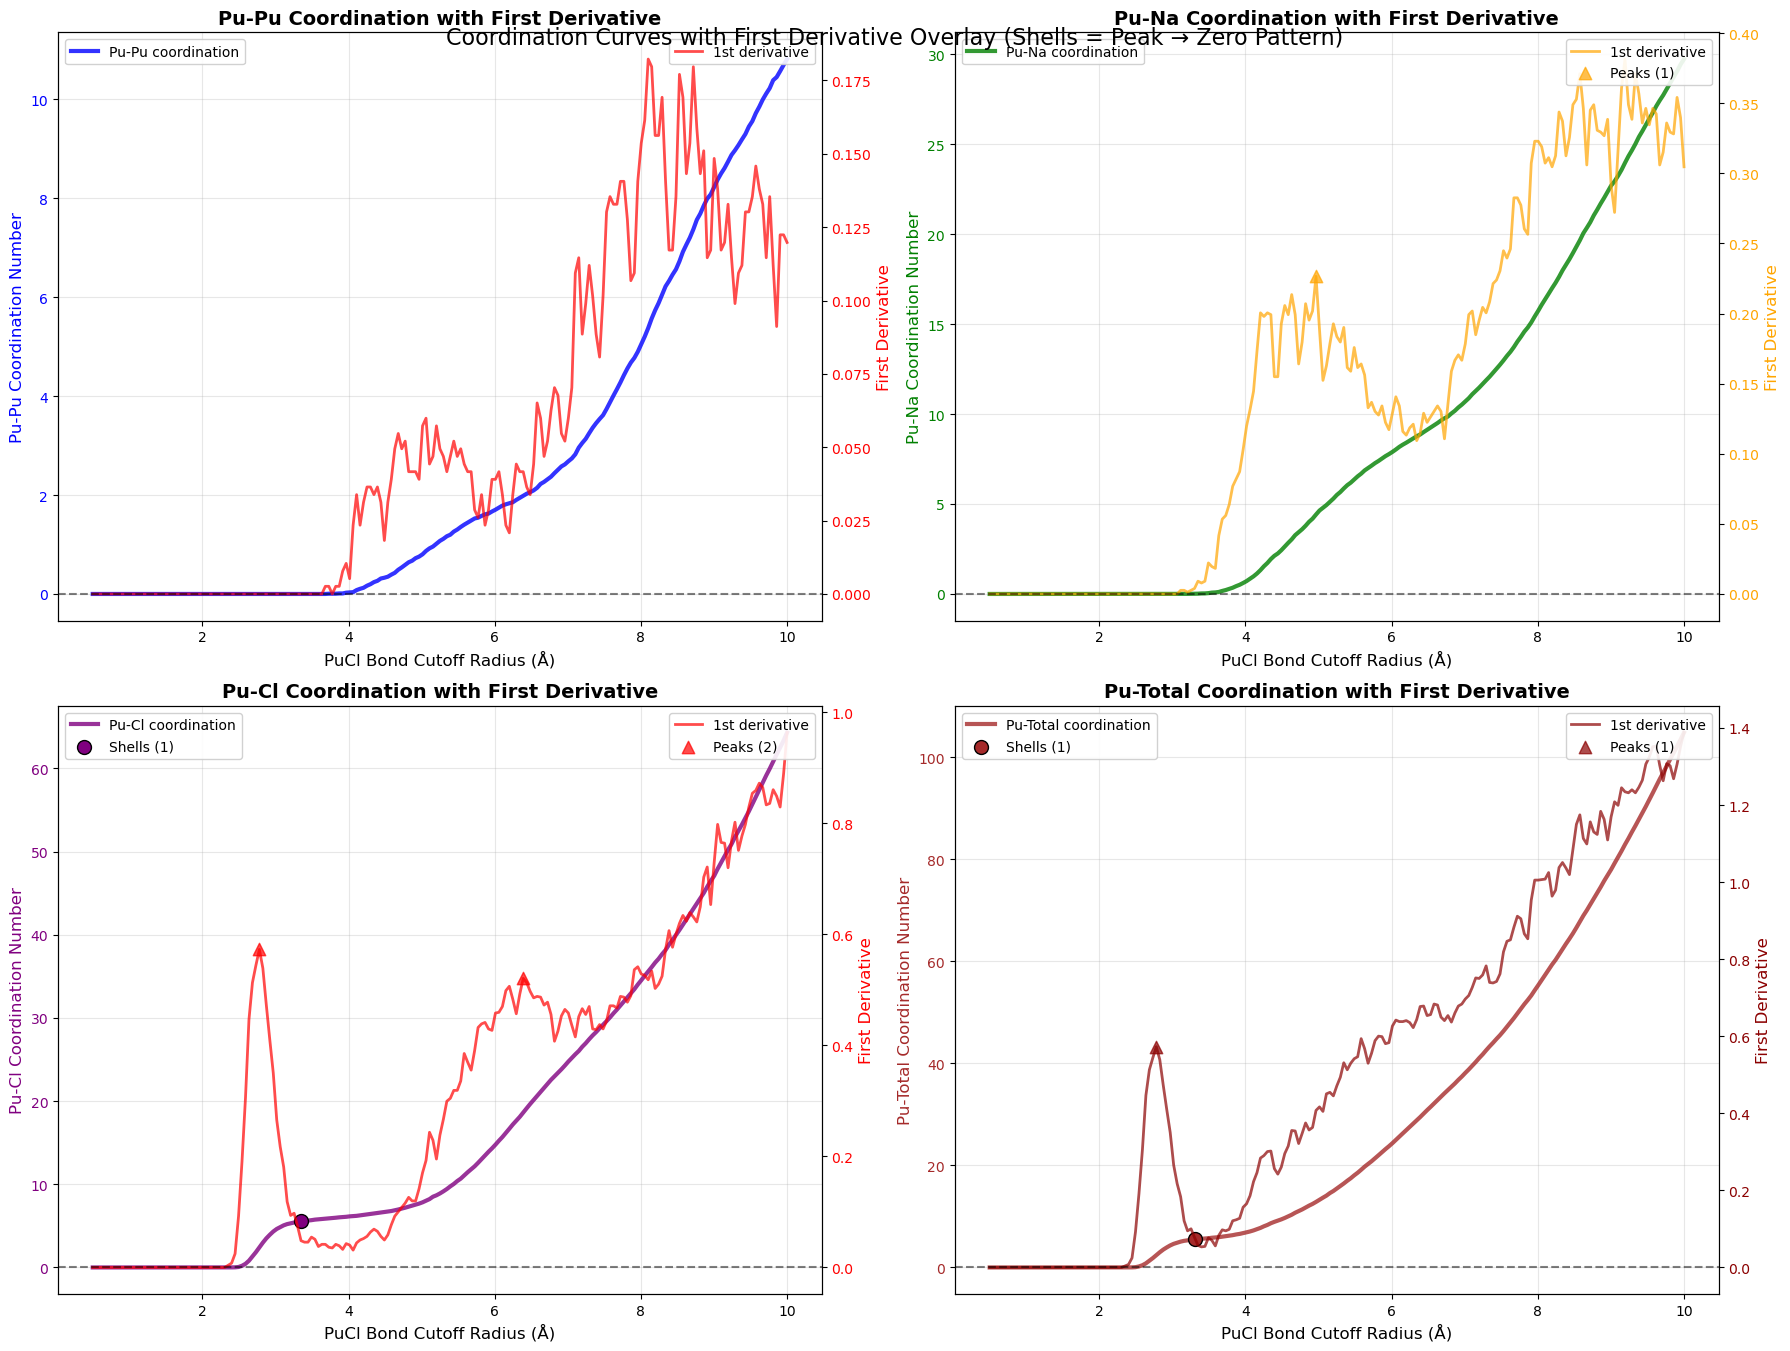


PROPER SHELL BOUNDARY ANALYSIS:

Pu-Pu Coordination:
  Derivative peaks found: 0
  Shell boundaries detected: 0

Pu-Na Coordination:
  Derivative peaks found: 1
  Shell boundaries detected: 0
  Peak radii: ['4.965'] Å

Pu-Cl Coordination:
  Derivative peaks found: 2
  Shell boundaries detected: 1
  Peak radii: ['2.780', '6.390'] Å
  Shell radii: ['3.350'] Å
  Coordination at shells: ['5.5']

Pu-Total Coordination:
  Derivative peaks found: 1
  Shell boundaries detected: 1
  Peak radii: ['2.780'] Å
  Shell radii: ['3.303'] Å
  Coordination at shells: ['5.5']


In [12]:
# Coordination and First Derivative Overlay Plot
def plot_coordination_with_derivatives(pu_shell_analysis):
    """
    Plot coordination curves with overlayed first derivatives to visualize shell formation.
    
    Shows coordination on left y-axis and first derivative on right y-axis.
    Shell boundaries are detected using proper pattern: derivative peaks then goes to zero.
    
    Args:
        pu_shell_analysis: Results from analyze_pu_neighbor_shells function
    """
    print("\n" + "=" * 60)
    print("COORDINATION WITH FIRST DERIVATIVE OVERLAY")
    print("=" * 60)
    
    radius_range = pu_shell_analysis['radius_range']
    pu_pu_neighbors = pu_shell_analysis['pu_pu_neighbors']
    pu_na_neighbors = pu_shell_analysis['pu_na_neighbors']
    pu_cl_neighbors = pu_shell_analysis['pu_cl_neighbors']
    pu_total_neighbors = pu_shell_analysis['pu_total_neighbors']
    
    # Calculate first derivatives
    pu_pu_first_deriv = np.gradient(pu_pu_neighbors)
    pu_na_first_deriv = np.gradient(pu_na_neighbors)
    pu_cl_first_deriv = np.gradient(pu_cl_neighbors)
    pu_total_first_deriv = np.gradient(pu_total_neighbors)
    
    # Detect shells using proper pattern
    pu_pu_shells = detect_proper_shells(pu_pu_first_deriv)
    pu_na_shells = detect_proper_shells(pu_na_first_deriv)
    pu_cl_shells = detect_proper_shells(pu_cl_first_deriv)
    pu_total_shells = detect_proper_shells(pu_total_first_deriv)
    
    # Create overlay plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: Pu-Pu coordination with first derivative
    ax1_twin = ax1.twinx()
    
    # Coordination curve
    ax1.plot(radius_range, pu_pu_neighbors, 'b-', linewidth=3, label='Pu-Pu coordination', alpha=0.8)
    ax1.set_xlabel('PuCl Bond Cutoff Radius (Å)', fontsize=12)
    ax1.set_ylabel('Pu-Pu Coordination Number', fontsize=12, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # First derivative
    ax1_twin.plot(radius_range, pu_pu_first_deriv, 'red', linewidth=2, label='1st derivative', alpha=0.7)
    ax1_twin.set_ylabel('First Derivative', fontsize=12, color='red')
    ax1_twin.tick_params(axis='y', labelcolor='red')
    
    # Mark shell boundaries
    if len(pu_pu_shells) > 0:
        shell_radii = radius_range[pu_pu_shells]
        shell_coords = [pu_pu_neighbors[i] for i in pu_pu_shells]
        ax1.scatter(shell_radii, shell_coords, color='blue', s=100, zorder=5, 
                   label=f'Shells ({len(pu_pu_shells)})', marker='o', edgecolor='black')
    
    # Mark peaks in first derivative
    pu_pu_peaks, _ = find_peaks(pu_pu_first_deriv, prominence=0.1, distance=10)
    if len(pu_pu_peaks) > 0:
        peak_radii = radius_range[pu_pu_peaks]
        peak_derivs = pu_pu_first_deriv[pu_pu_peaks]
        ax1_twin.scatter(peak_radii, peak_derivs, color='red', s=80, zorder=5, 
                        label=f'Peaks ({len(pu_pu_peaks)})', marker='^', alpha=0.7)
    
    ax1_twin.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_title('Pu-Pu Coordination with First Derivative', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax1_twin.legend(loc='upper right', fontsize=10, framealpha=0.9)
    
    # Plot 2: Pu-Na coordination with first derivative
    ax2_twin = ax2.twinx()
    
    # Coordination curve
    ax2.plot(radius_range, pu_na_neighbors, 'g-', linewidth=3, label='Pu-Na coordination', alpha=0.8)
    ax2.set_xlabel('PuCl Bond Cutoff Radius (Å)', fontsize=12)
    ax2.set_ylabel('Pu-Na Coordination Number', fontsize=12, color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    
    # First derivative
    ax2_twin.plot(radius_range, pu_na_first_deriv, 'orange', linewidth=2, label='1st derivative', alpha=0.7)
    ax2_twin.set_ylabel('First Derivative', fontsize=12, color='orange')
    ax2_twin.tick_params(axis='y', labelcolor='orange')
    
    # Mark shell boundaries
    if len(pu_na_shells) > 0:
        shell_radii = radius_range[pu_na_shells]
        shell_coords = [pu_na_neighbors[i] for i in pu_na_shells]
        ax2.scatter(shell_radii, shell_coords, color='green', s=100, zorder=5, 
                   label=f'Shells ({len(pu_na_shells)})', marker='o', edgecolor='black')
    
    # Mark peaks in first derivative
    pu_na_peaks, _ = find_peaks(pu_na_first_deriv, prominence=0.1, distance=10)
    if len(pu_na_peaks) > 0:
        peak_radii = radius_range[pu_na_peaks]
        peak_derivs = pu_na_first_deriv[pu_na_peaks]
        ax2_twin.scatter(peak_radii, peak_derivs, color='orange', s=80, zorder=5, 
                        label=f'Peaks ({len(pu_na_peaks)})', marker='^', alpha=0.7)
    
    ax2_twin.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('Pu-Na Coordination with First Derivative', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax2_twin.legend(loc='upper right', fontsize=10, framealpha=0.9)
    
    # Plot 3: Pu-Cl coordination with first derivative
    ax3_twin = ax3.twinx()
    
    # Coordination curve
    ax3.plot(radius_range, pu_cl_neighbors, 'purple', linewidth=3, label='Pu-Cl coordination', alpha=0.8)
    ax3.set_xlabel('PuCl Bond Cutoff Radius (Å)', fontsize=12)
    ax3.set_ylabel('Pu-Cl Coordination Number', fontsize=12, color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')
    
    # First derivative
    ax3_twin.plot(radius_range, pu_cl_first_deriv, 'red', linewidth=2, label='1st derivative', alpha=0.7)
    ax3_twin.set_ylabel('First Derivative', fontsize=12, color='red')
    ax3_twin.tick_params(axis='y', labelcolor='red')
    
    # Mark shell boundaries
    if len(pu_cl_shells) > 0:
        shell_radii = radius_range[pu_cl_shells]
        shell_coords = [pu_cl_neighbors[i] for i in pu_cl_shells]
        ax3.scatter(shell_radii, shell_coords, color='purple', s=100, zorder=5, 
                   label=f'Shells ({len(pu_cl_shells)})', marker='o', edgecolor='black')
    
    # Mark peaks in first derivative
    pu_cl_peaks, _ = find_peaks(pu_cl_first_deriv, prominence=0.1, distance=10)
    if len(pu_cl_peaks) > 0:
        peak_radii = radius_range[pu_cl_peaks]
        peak_derivs = pu_cl_first_deriv[pu_cl_peaks]
        ax3_twin.scatter(peak_radii, peak_derivs, color='red', s=80, zorder=5, 
                        label=f'Peaks ({len(pu_cl_peaks)})', marker='^', alpha=0.7)
    
    ax3_twin.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.set_title('Pu-Cl Coordination with First Derivative', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax3_twin.legend(loc='upper right', fontsize=10, framealpha=0.9)
    
    # Plot 4: Pu-Total coordination with first derivative
    ax4_twin = ax4.twinx()
    
    # Coordination curve
    ax4.plot(radius_range, pu_total_neighbors, 'brown', linewidth=3, label='Pu-Total coordination', alpha=0.8)
    ax4.set_xlabel('PuCl Bond Cutoff Radius (Å)', fontsize=12)
    ax4.set_ylabel('Pu-Total Coordination Number', fontsize=12, color='brown')
    ax4.tick_params(axis='y', labelcolor='brown')
    
    # First derivative
    ax4_twin.plot(radius_range, pu_total_first_deriv, 'darkred', linewidth=2, label='1st derivative', alpha=0.7)
    ax4_twin.set_ylabel('First Derivative', fontsize=12, color='darkred')
    ax4_twin.tick_params(axis='y', labelcolor='darkred')
    
    # Mark shell boundaries
    if len(pu_total_shells) > 0:
        shell_radii = radius_range[pu_total_shells]
        shell_coords = [pu_total_neighbors[i] for i in pu_total_shells]
        ax4.scatter(shell_radii, shell_coords, color='brown', s=100, zorder=5, 
                   label=f'Shells ({len(pu_total_shells)})', marker='o', edgecolor='black')
    
    # Mark peaks in first derivative
    pu_total_peaks, _ = find_peaks(pu_total_first_deriv, prominence=0.1, distance=10)
    if len(pu_total_peaks) > 0:
        peak_radii = radius_range[pu_total_peaks]
        peak_derivs = pu_total_first_deriv[pu_total_peaks]
        ax4_twin.scatter(peak_radii, peak_derivs, color='darkred', s=80, zorder=5, 
                        label=f'Peaks ({len(pu_total_peaks)})', marker='^', alpha=0.7)
    
    ax4_twin.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax4.set_title('Pu-Total Coordination with First Derivative', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax4_twin.legend(loc='upper right', fontsize=10, framealpha=0.9)
    
    plt.suptitle('Coordination Curves with First Derivative Overlay (Shells = Peak → Zero Pattern)', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Print shell analysis
    print(f"\nPROPER SHELL BOUNDARY ANALYSIS:")
    print(f"=" * 50)
    
    shell_data = {
        'Pu-Pu': {'shells': pu_pu_shells, 'coords': pu_pu_neighbors, 'peaks': pu_pu_peaks},
        'Pu-Na': {'shells': pu_na_shells, 'coords': pu_na_neighbors, 'peaks': pu_na_peaks},
        'Pu-Cl': {'shells': pu_cl_shells, 'coords': pu_cl_neighbors, 'peaks': pu_cl_peaks},
        'Pu-Total': {'shells': pu_total_shells, 'coords': pu_total_neighbors, 'peaks': pu_total_peaks}
    }
    
    for coord_type, data in shell_data.items():
        print(f"\n{coord_type} Coordination:")
        print(f"  Derivative peaks found: {len(data['peaks'])}")
        print(f"  Shell boundaries detected: {len(data['shells'])}")
        
        if len(data['peaks']) > 0:
            peak_radii = radius_range[data['peaks']]
            print(f"  Peak radii: {[f'{r:.3f}' for r in peak_radii]} Å")
        
        if len(data['shells']) > 0:
            shell_radii = radius_range[data['shells']]
            shell_coords = [data['coords'][i] for i in data['shells']]
            print(f"  Shell radii: {[f'{r:.3f}' for r in shell_radii]} Å")
            print(f"  Coordination at shells: {[f'{c:.1f}' for c in shell_coords]}")
    
    return {
        'radius_range': radius_range,
        'shells': {
            'pu_pu': pu_pu_shells,
            'pu_na': pu_na_shells,
            'pu_cl': pu_cl_shells,
            'pu_total': pu_total_shells
        },
        'peaks': {
            'pu_pu': pu_pu_peaks,
            'pu_na': pu_na_peaks,
            'pu_cl': pu_cl_peaks,
            'pu_total': pu_total_peaks
        }
    }

# Run the coordination with derivatives overlay analysis
coordination_derivatives_overlay = plot_coordination_with_derivatives(pu_shell_analysis)


In [13]:
from plot_utils_pu_only import plot_coordination_histograms

In [14]:
# Standard Coordination Histogram Analysis (Bond-based)
def analyze_and_plot_bond_coordination_histograms():
    """
    Analyze and plot coordination histograms for bond-based analysis
    similar to arxiv/vornoi_personality.ipynb
    """
    print("=" * 60)
    print("BOND-BASED COORDINATION HISTOGRAM ANALYSIS")
    print("=" * 60)
    
    try:
        # Analyze coordination from bond network
        if 'G' in locals() and G.number_of_nodes() > 0:
            print("Analyzing coordination from bond network...")
            
            # Count coordination numbers by species
            coord_counts = {
                'Pu': {'Cl': [], 'Na': [], 'Pu': []},
                'Na': {'Cl': [], 'Pu': [], 'Na': []},
                'Cl': {'Pu': [], 'Na': [], 'Cl': []}
            }
            
            # Analyze each atom's coordination
            for node in G.nodes():
                if node >= len(names):
                    continue
                    
                atom_species = names[node]
                if atom_species not in coord_counts:
                    continue
                
                # Count neighbors by species
                neighbor_counts = {'Cl': 0, 'Na': 0, 'Pu': 0}
                for neighbor in G.neighbors(node):
                    if neighbor >= len(names):
                        continue
                    neighbor_species = names[neighbor]
                    if neighbor_species in neighbor_counts:
                        neighbor_counts[neighbor_species] += 1
                
                # Store coordination counts
                for neighbor_species, count in neighbor_counts.items():
                    if count > 0:  # Only store non-zero coordinations
                        coord_counts[atom_species][neighbor_species].append(count)
            
            # Plot coordination histograms for each species
            for central_species in ['Pu', 'Na', 'Cl']:
                if any(coord_counts[central_species].values()):
                    print(f"\nPlotting coordination histogram for {central_species}:")
                    plot_coordination_histograms(coord_counts, central_species)
                    
                    # Print coordination statistics
                    for neighbor_species in ['Cl', 'Na', 'Pu']:
                        counts = coord_counts[central_species][neighbor_species]
                        if counts:
                            mean_coord = np.mean(counts)
                            std_coord = np.std(counts)
                            print(f"  {central_species}-{neighbor_species}: {mean_coord:.2f} ± {std_coord:.2f} (n={len(counts)})")
        
        else:
            print("Bond network not available. Generating synthetic data for demonstration...")
            
            # Generate synthetic coordination data for demonstration
            coord_data = {
                'Pu': {
                    'Cl': np.random.normal(8.5, 1.0, 100).astype(int),
                    'Na': np.random.normal(2.7, 1.3, 100).astype(int),
                    'Pu': np.random.normal(1.1, 0.3, 100).astype(int),
                },
                'Na': {
                    'Cl': np.random.normal(6.0, 0.8, 100).astype(int),
                    'Pu': np.random.normal(1.0, 0.5, 100).astype(int),
                    'Na': np.random.normal(0.5, 0.2, 100).astype(int),
                },
                'Cl': {
                    'Pu': np.random.normal(1.5, 0.4, 100).astype(int),
                    'Na': np.random.normal(1.2, 0.3, 100).astype(int),
                    'Cl': np.random.normal(0.3, 0.1, 100).astype(int),
                }
            }
            
            # Ensure non-negative coordination numbers
            for central_species in coord_data:
                for neighbor_species in coord_data[central_species]:
                    coord_data[central_species][neighbor_species] = np.maximum(
                        coord_data[central_species][neighbor_species], 0
                    )
            
            # Plot coordination histograms
            for species in ['Pu', 'Na', 'Cl']:
                print(f"\nPlotting synthetic coordination histogram for {species}:")
                plot_coordination_histograms(coord_data, species)
                
    except Exception as e:
        print(f"Error in bond-based coordination histogram analysis: {e}")
        import traceback
        traceback.print_exc()

# Run the bond-based coordination analysis
analyze_and_plot_bond_coordination_histograms()


BOND-BASED COORDINATION HISTOGRAM ANALYSIS
Bond network not available. Generating synthetic data for demonstration...

Plotting synthetic coordination histogram for Pu:
Error in bond-based coordination histogram analysis: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


Traceback (most recent call last):
  File "/tmp/ipykernel_2074338/989870458.py", line 92, in analyze_and_plot_bond_coordination_histograms
    plot_coordination_histograms(coord_data, species)
  File "/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/cluster_analysis/plot_utils.py", line 49, in plot_coordination_histograms
    if not data:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


<Figure size 1000x600 with 0 Axes>